# 第9章: RNN, CNN
## 80. ID番号への変換

問題51で構築した学習データ中の単語にユニークなID番号を付与したい．学習データ中で最も頻出する単語に1，2番目に頻出する単語に2，……といった方法で，学習データ中で2回以上出現する単語にID番号を付与せよ．そして，与えられた単語列に対して，ID番号の列を返す関数を実装せよ．ただし，出現頻度が2回未満の単語のID番号はすべて0とせよ．

**ここではつまり，トークナイズしている**  
まず、第6章の問題50と同じようにデータを準備する。


In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip

--2021-07-14 01:30:47--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  91.6MB/s    in 0.3s    

2021-07-14 01:30:48 (91.6 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]



In [ ]:
!unzip "NewsAggregatorDataset.zip"

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [ ]:
!head -10 ./newsCorpora.csv 

1	Fed official says weak data caused by weather, should not slow taper	http://www.latimes.com/business/money/la-fi-mo-federal-reserve-plosser-stimulus-economy-20140310,0,1312750.story\?track=rss	Los Angeles Times	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.latimes.com	1394470370698
2	Fed's Charles Plosser sees high bar for change in pace of tapering	http://www.livemint.com/Politics/H2EvwJSK2VE6OF7iK1g3PP/Feds-Charles-Plosser-sees-high-bar-for-change-in-pace-of-ta.html	Livemint	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.livemint.com	1394470371207
3	US open: Stocks fall after Fed official hints at accelerated tapering	http://www.ifamagazine.com/news/us-open-stocks-fall-after-fed-official-hints-at-accelerated-tapering-294436	IFA Magazine	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.ifamagazine.com	1394470371550
4	Fed risks falling 'behind the curve', Charles Plosser says	http://www.ifamagazine.com/news/fed-risks-falling-behind-the-curve-charles-plosser-says-294430	IFA Magazine	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www

In [ ]:
# 読込時のエラー回避のためダブルクォーテーションをシングルクォーテーションに置換
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

## データ読み込み
df = pd.read_csv('./newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

## データ抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']),['TITLE', 'CATEGORY']]

## データ分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])

## データ保存
train.to_csv('./train.txt', sep='\t', index=False)
valid.to_csv('./valid.txt', sep='\t', index=False)
test.to_csv('./test.txt', sep='\t', index=False )

In [ ]:
## 事例数の確認
print("カテゴリ:(b = business, t = science and technology, e = entertainment, m = health)")
print('---学習データ---')
print(train['CATEGORY'].value_counts())
print('---検証データ---')
print(valid['CATEGORY'].value_counts())
print('---評価データ---')
print(test['CATEGORY'].value_counts())

カテゴリ:(b = business, t = science and technology, e = entertainment, m = health)
---学習データ---
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
---検証データ---
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
---評価データ---
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


In [ ]:
df = pd.concat([train, valid, test], axis=0)
df.reset_index(drop=True, inplace=True)

テキスト前処理をしておく
- 記号をスペースに変換
- アルファベットを小文字にする
- 数字を0に置換


In [ ]:
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [ ]:
import string
import re

## 事前処理関数
def pre(text):
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  text = text.translate(table)
  text = text.lower()
  text = re.sub('[0-9]+', '0', text)
  return text

In [ ]:
## 事前処理
df['TITLE'] =df['TITLE'].map(lambda x : pre(x))

In [ ]:
df.head()

TITLE CATEGORY
0  refile update 0 european car sales up for sixt...        b
1  amazon plans to fight ftc over mobile app purc...        t
2  kids still get codeine in emergency rooms desp...        m
3  what on earth happened between solange and jay...        e
4  nato missile defense is flight tested over hawaii        b

学習データ中の頻出単語を調べた後に、それに基づいて構築した学習データ中にユニークなID番号を付加していく。

In [ ]:
from collections import defaultdict

**2021/02/23追記：`word2id`を`pd.DataFrame`型から`dict`型へ変更**

In [ ]:
# 単語の頻度集計
d = defaultdict(int)
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))  # 記号をスペースに置換するテーブル
for title in train['TITLE']:
  for word in title.translate(table).split():
    ## 記号処理・小文字処理
    #word = pre(word)
    if word != '':
      d[word] += 1  ## 頻度をカウント
d = sorted(d.items(), key=lambda x:x[1], reverse=True)

## 辞書IDをDataFrame型で作成
#word2id = pd.DataFrame(d, columns=['word', 'sum'])
## 出現回数が2回以上の単語のみを登録
#word2id = word2id.loc[word2id['sum']>1]

## 辞書IDをdict型で作成
word2id = {word : i+1 for i,(word,cnt) in enumerate(d) if cnt>1 }


In [ ]:
type(word2id)

dict

In [ ]:
len(word2id) ## 大文字を小文字に変換していない 

9405

大文字を小文字に変えてすることで，精度向上しそう

In [ ]:
## 上位5位の頻出単語
for i in range(30):
  print(list(word2id)[i])
## 小文字にするべき

to
s
in
on
UPDATE
as
US
for
The
of
1
To
2
the
and
In
Of
a
at
A
With
Is
For
with
And
after
3
New
China
Kardashian


**2021/02/23追記：`word2id`を`pd.DataFrame`型から`dict`型へ変更したため、’toID()’の内部処理も変更**  
理由は後述する

In [ ]:
##def toID(words, word2id=word2id):
##  id_list = []
##  for word in words.split(' '):
##    
##    ## 単語が存在しない場合
##    if word2id[word2id['word']==word].empty :
##      id = 0  
##    
##    ## 存在する場合
##    else:
##      id = word2id[word2id['word']==word].index[0] + 1
##    id_list.append(id)
##  return id_list

In [ ]:
def toID(words, word2id=word2id):
  id_list = []
  for word in words.split(' '):
    ## 単語が存在する場合
    if word in word2id:
      id_list.append(word2id[word])
    ## 単語が存在しない場合
    else:
      id_list.append(0)
  return id_list

In [ ]:
## 'root'は出現回数が1回
print(toID('root'))
## 存在する文字列
print(toID('thanks for being you'))

[0]
[6318, 8, 627, 452]


In [ ]:
## 存在しない単語
toID('rdgdfgae')

[0]

## 81. RNNによる予測
ID番号で表現された単語列$\boldsymbol{x} = (x_1, x_2, \dots, x_T)$がある．ただし，$T$は単語列の長さ，$x_t \in \mathbb{R}^{V}$は単語のID番号のone-hot表記である（$V$は単語の総数である）．再帰型ニューラルネットワーク（RNN: Recurrent Neural Network）を用い，単語列$\boldsymbol{x}$からカテゴリ$y$を予測するモデルとして，次式を実装せよ．


$$
\overrightarrow h_0 = 0,\\
\overrightarrow h_t = {\rm \overrightarrow{RNN}}(\mathrm{emb}(x_t), \overrightarrow h_{t-1}), \\
y = {\rm softmax}(W^{(yh)} \overrightarrow h_T + b^{(y)})
$$


ただし，$\mathrm{emb}(x) \in \mathbb{R}^{d_w}$は単語埋め込み（単語のone-hot表記から単語ベクトルに変換する関数），$\overrightarrow h_t \in \mathbb{R}^{d_h}$は時刻$t$の隠れ状態ベクトル，${\rm \overrightarrow{RNN}}(x,h)$は入力$x$と前時刻の隠れ状態$h$から次状態を計算するRNNユニット，$W^{(yh)} \in \mathbb{R}^{L \times d_h}$は隠れ状態ベクトルからカテゴリを予測するための行列，$b^{(y)} \in \mathbb{R}^{L}$はバイアス項である（$d_w, d_h, L$はそれぞれ，単語埋め込みの次元数，隠れ状態ベクトルの次元数，ラベル数である）．RNNユニット${\rm \overrightarrow{RNN}}(x,h)$には様々な構成が考えられるが，典型例として次式が挙げられる．

$$
{\rm \overrightarrow{RNN}}(x,h) = g(W^{(hx)} x + W^{(hh)}h + b^{(h)})
$$

ただし，$W^{(hx)} \in \mathbb{R}^{d_h \times d_w}，W^{(hh)} \in \mathbb{R}^{d_h \times d_h}, b^{(h)} \in \mathbb{R}^{d_h}$はRNNユニットのパラメータ，$g$は活性化関数（例えば$\tanh$やReLUなど）である．

なお，この問題ではパラメータの学習を行わず，ランダムに初期化されたパラメータで$y$を計算するだけでよい．次元数などのハイパーパラメータは，$d_w = 300, d_h=50$など，適当な値に設定せよ（以降の問題でも同様である）．

**ニューラルネット**を用いた自然言語処理の流れは以下の通りである。

1. 文をトークン（例えば単語）の列に分割
2. それぞれのトークンをベクトルに変換
3. トークンベクトルを文ベクトルとして1つに集約 
4. 文ベクトルを入力としてラベルを分類

**ニューラルネットでやっていたことを図で表すと以下の通り**   
**※今回やっているRNNではない**



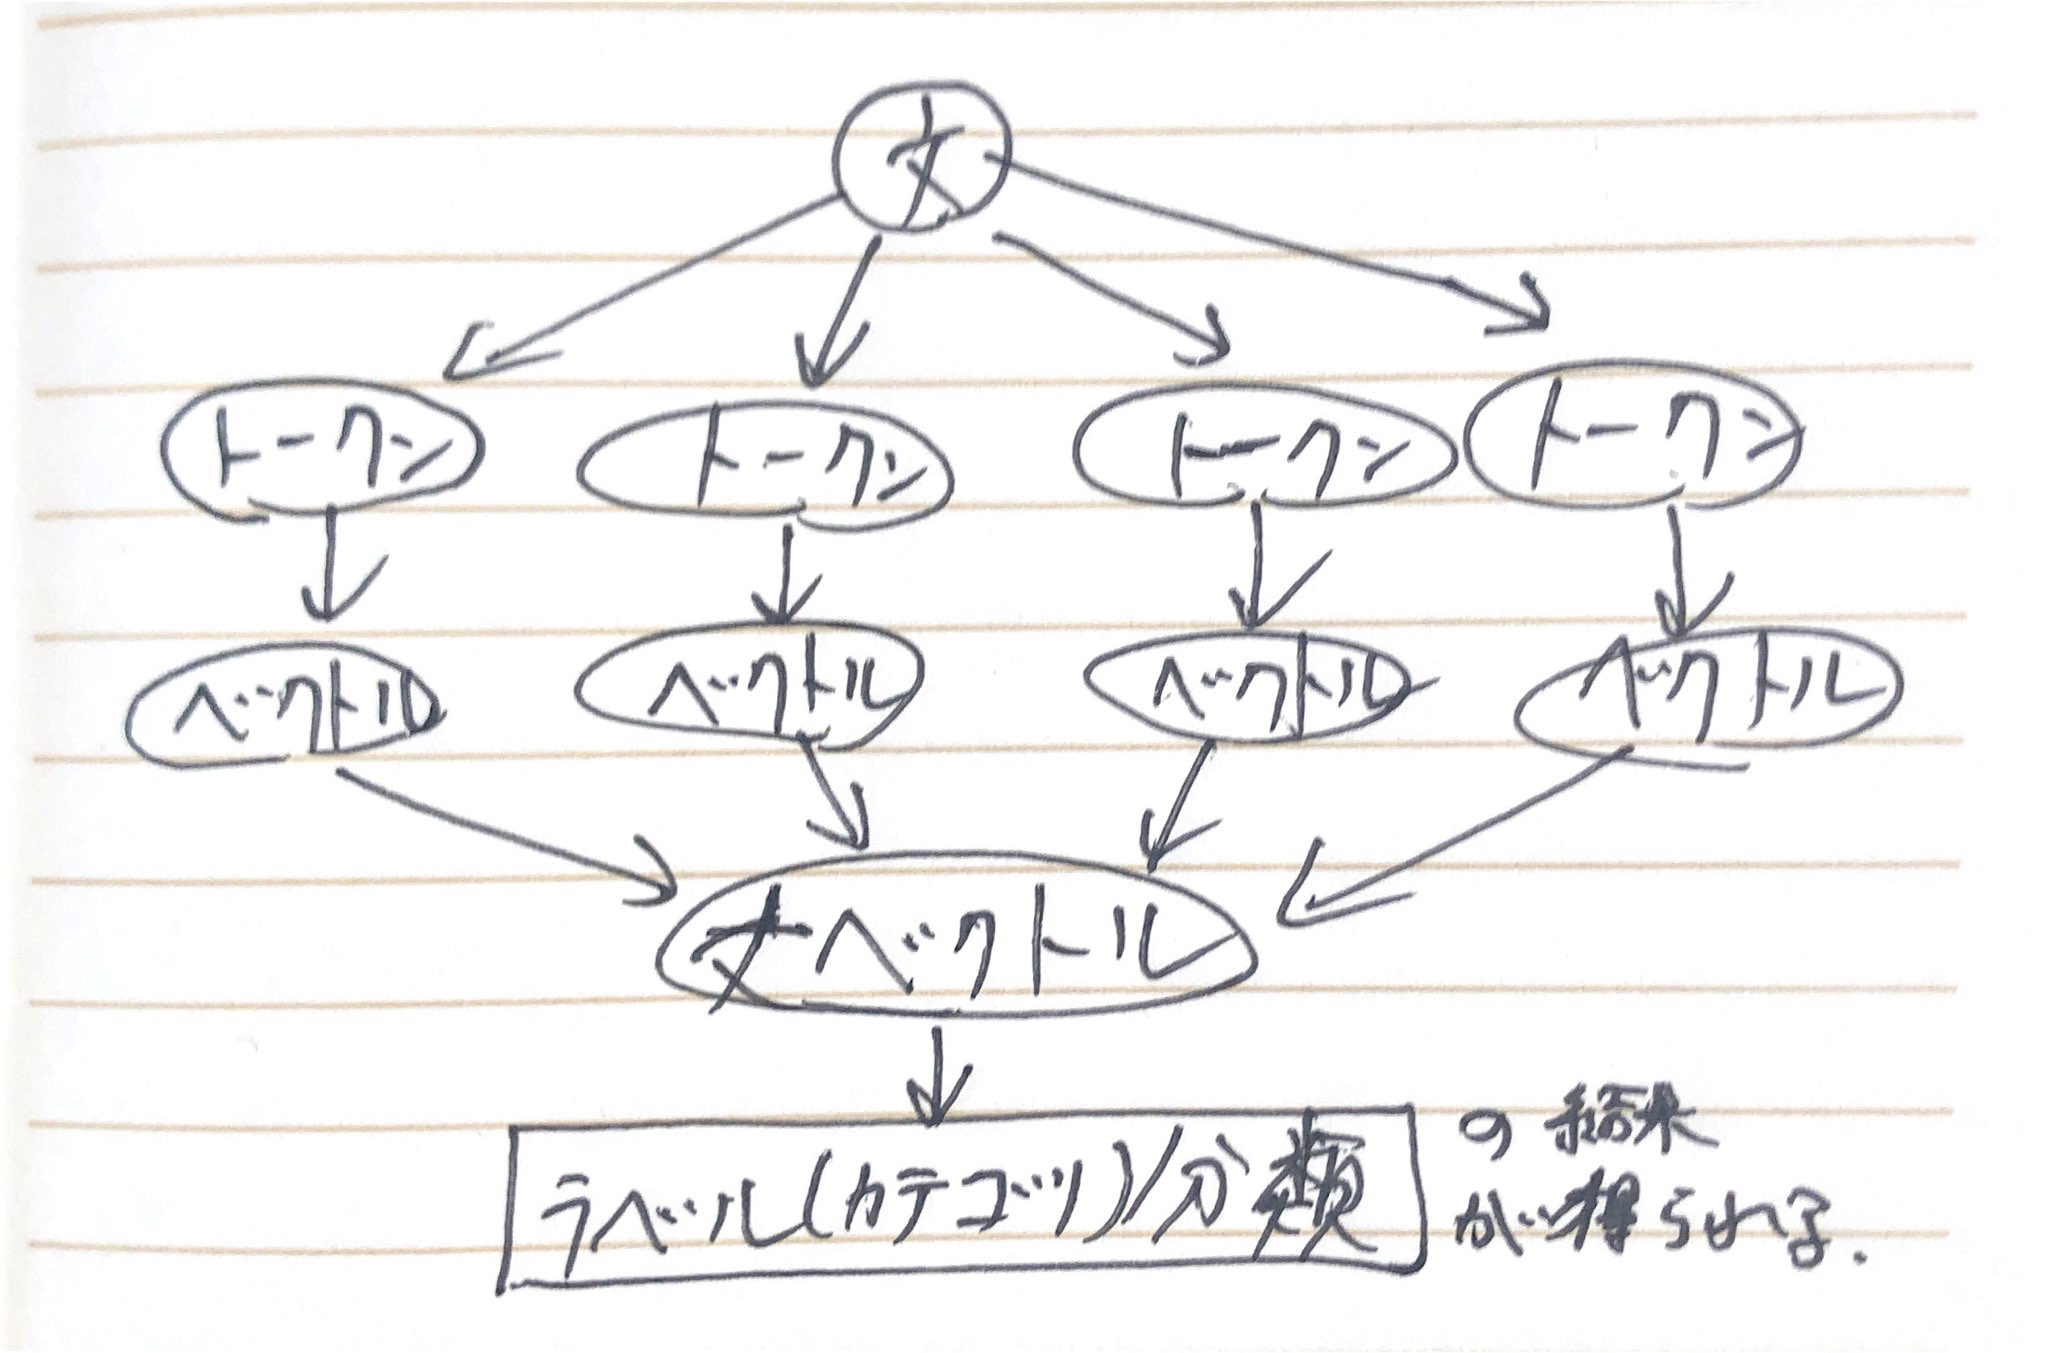

前回の8章：ニューラルネットでは、

1. 文をトークン（例えば単語）の列に分割 
   ⇒ **スペースで分割**
2. それぞれのトークンをベクトルに変換
   ⇒ **事前学習済みWord2Vecで変換**
3. トークンベクトルを文ベクトルとして1つに集約
   ⇒ **トークンベクトルを平均**
4. 文ベクトルを入力としてラベルを分類
   ⇒ **全結合層で分類**

の流れで実装していた。ここでニューラルネット上でパラメータの学習を行っていたのは4番目の部分のみである。

それに対し、本章では、

1. 文をトークン（例えば単語）の列に分割
   ⇒ スペースで分割
2. それぞれのトークンをベクトルに変換
   ⇒ **埋め込み層で変換(どんな特徴量かを学習)**
3. トークンベクトルを文ベクトルとして1つに集約
   ⇒ **RNNまたはCNNで集約**
4. 文ベクトルを入力としてラベルを分類
   ⇒ 全結合層で分類

の流れで実装する。前章とは異なり、2番目から4番目を繋げたネットワークのパラメータを学習していく。


### RNNとは
通常のニューラルネットワークでは、ある層の出力は、次の層の入力に利用されるのみである。しかしRNNでは、ある層の出力は、次の層の入力として利用されるだけでなく、一般的なニューラルネットワークの最後の層のような（中間データではないユーザーが利用可能な）出力としても利用される。また、各層の入力として、前の層の入力のみではなく、時系列のデータポイントも入力とする。  
図で表すと以下の通り。

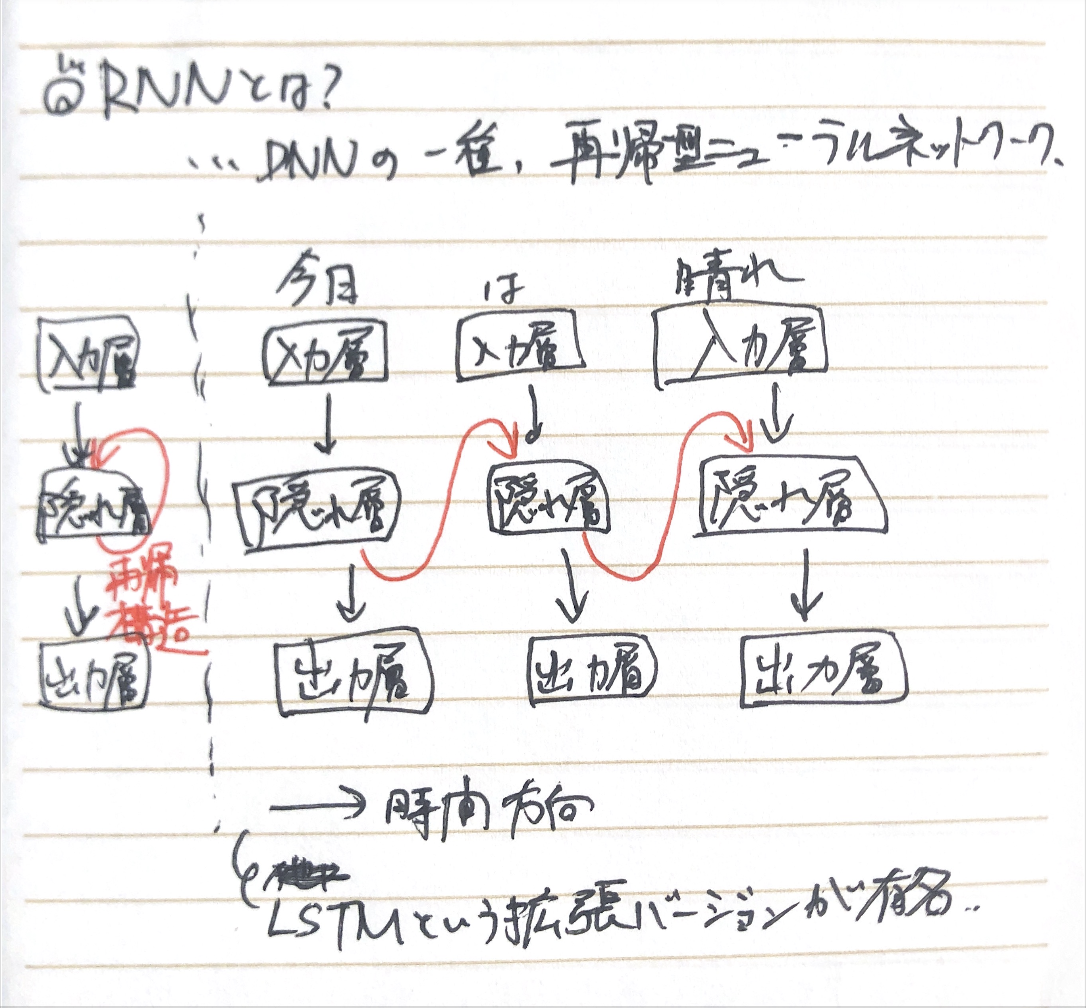

### RNNの得意・不得意
#### 得意
+ 入力の順番，時系列が重要なタスク

#### 不得意
+ 長期的な依存関係を追うこと
+ 並列計算ができないため，CNNやTransformerを比べて計算が遅い

今回のタスクは，以下の図の場合，緑で示した入力と出力を使用している．  
入力：$x^{(0)}～x^{(T)}$  ．．．「系列データ(可変長)」  
出力：$y^{(T)}, h^{(T)}$　．．．「非系列データ(固定次元ベクトル)」  
ここでの$h^{(T)}$は，**全部の入力を見た結果，入力に対して理解できた意味，入力系列のお気持ちを特徴として持っている**  
これをsoftmaxすることで，入力系列の分類を行っている．

[![Image from Gyazo](https://i.gyazo.com/2e17a0d878a8d90246d244ec0e19c9b3.png)](https://gyazo.com/2e17a0d878a8d90246d244ec0e19c9b3)

Pytorchの単語埋め込み`nn.Embedding`の使い方は以下のサイトを参考にした。  
[【Pytorch】nn.Embeddingの使い方を丁寧に](https://gotutiyan.hatenablog.com/entry/2020/09/02/200144)  
この単語埋め込みって，どうやってきめているの？？  
→どうやらランダムな単語ベクトル群らしい  
https://qiita.com/m__k/items/841950a57a0d7ff05506

埋め込み層にはnn.Embedding使う．この層は、単語IDを与えるとone-hotベクトルに変換した後、指定したサイズ（emb_size）のベクトルに変換する。  
この埋め込み層のパラメータも学習している？🤔

Pytorchの`nn.RNN`について  
https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [ ]:
class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size, device=None):
    super().__init__()
    self.hidden_size = hidden_size
    self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, nonlinearity='tanh', batch_first=True)#ここのnn.RNNに入れるだけで確か，再帰的に動作してくれるはず
    self.fc = nn.Linear(hidden_size, output_size)
  
  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden()
    emb = self.emb(x)
    # embのsizeは， (batch_size, seq_len, emb_size)
    output, hidden = self.rnn(emb, hidden)
    # outputのsizeは， (batch_size, seq_len, hidden_size)
    #print(output)
    #print(output[:, -1, :])
    output = self.fc(output[:, -1, :]) #[:, -1, :]は最後のSequenceのベクトルを取っている．
    # outputのsizeは，(batch_size, output_size)
    return output

  def init_hidden(self):
    hidden = torch.zeros(1, self.batch_size, self.hidden_size).to(device)
    return hidden

もし，RNNCellを利用したRNNを作るなら，Forward部分のように，hidden部分が再帰的になる．
https://www.atmarkit.co.jp/ait/articles/2006/26/news024.html

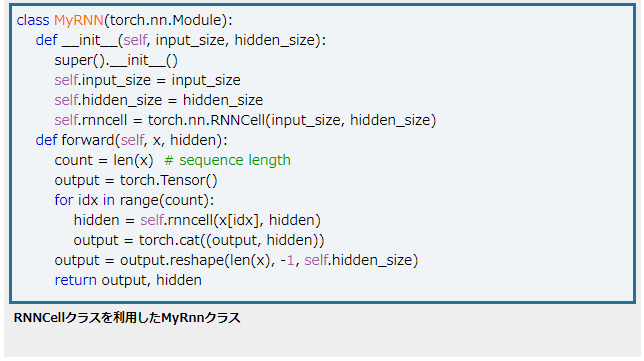

8章と同様にデータセットとデータローダを作成する。  
PyTorchのDataset, Dataloaderを使用する。

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
## 自作Datasetクラス
class MyDataset(Dataset):
  def __init__(self, X, y, toID):
    self.X = X
    self.y = y
    self.toID = toID

  def __len__(self):  # len(Dataset)の返り値を定義
    return len(self.y)
    
  def __getitem__(self, index):  # Dataset[index]の返り値を定義
    input_id = self.toID(self.X[index])
    return torch.tensor(input_id, dtype=torch.int64), torch.tensor(self.y[index], dtype=torch.int64)
    

In [ ]:
## ラベルベクトル作成
label_dic ={'b':0, 't':1, 'e':2, 'm':3}
y_train = torch.tensor([label_dic[label] for label in train['CATEGORY']])
y_valid = torch.tensor([label_dic[label] for label in valid['CATEGORY']])
y_test =  torch.tensor([label_dic[label] for label in test['CATEGORY']])


In [ ]:
y_train

tensor([0, 1, 3,  ..., 0, 3, 2])

In [ ]:
train.reset_index(inplace=True, drop=True)
valid.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

In [ ]:
## Dataset作成
dataset_train = MyDataset(train['TITLE'], y_train, toID)
dataset_valid = MyDataset(valid['TITLE'], y_valid, toID)
dataset_test = MyDataset(test['TITLE'], y_test, toID)

In [ ]:
dataset_train[1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


(tensor([ 169,  539,    1,  683, 1237,   82,    0, 4199]), tensor(1))

In [ ]:
## detasetの確認
print(f'len(dataset_train):{len(dataset_train)}')
print('Dataset[index]の出力:')
inputs,labels = dataset_train[1]
print(f'  inputs:{inputs}\n  labels:{labels}')

len(dataset_train):10684
Dataset[index]の出力:
  inputs:tensor([ 169,  539,    1,  683, 1237,   82,    0, 4199])
  labels:1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


In [ ]:
train['TITLE'][1]

'Amazon Plans to Fight FTC Over Mobile-App Purchases'

In [ ]:
toID('Amazon Plans to Fight FTC Over Mobile-App Purchases')

[169, 539, 1, 683, 1237, 82, 0, 4199]

In [ ]:
## DataLoader作成
loader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
loader_valid = DataLoader(dataset_valid, batch_size=len(y_valid), shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=len(y_test), shuffle=False)

In [ ]:
## パラメータの設定
VOCAB_SIZE = len(word2id) + 1
EMB_SIZE = 300
PADDING_IDX = len(word2id)
HIDDEN_SIZE = 50
OUTPUT_SIZE = 4

model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, HIDDEN_SIZE, OUTPUT_SIZE)

## 先頭5件の予測値を取得
for i in range(5):
  X,y = dataset_train[i]
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[[ 0.8862, -0.8499, -1.0000, -0.8705],
         [ 0.9024, -0.9198, -1.0000, -0.7679],
         [-0.9982,  0.8219,  0.7066, -1.0000],
         [ 0.9971,  0.6702, -0.9896, -1.0000],
         [ 0.9995, -0.5494, -1.0000,  0.8384],
         [ 1.0000, -1.0000, -0.9994,  0.9998],
         [-1.0000,  1.0000, -1.0000,  1.0000],
         [-0.9995, -1.0000,  0.9832, -0.9999],
         [-0.8563,  0.9999, -0.9992, -1.0000],
         [ 0.9910,  0.9910, -0.0781,  0.9851],
         [ 0.9996, -0.1689,  0.9821,  0.6493]]], grad_fn=<TransposeBackward1>)
tensor([[0.0114, 0.0201, 0.0375, 0.0154, 0.0184, 0.0149, 0.0166, 0.0088, 0.0121,
         0.0157, 0.0282, 0.0235, 0.0184, 0.0134, 0.0249, 0.0346, 0.0199, 0.0060,
         0.0090, 0.0165, 0.0174, 0.0326, 0.0418, 0.0086, 0.0118, 0.0300, 0.0125,
         0.0294, 0.0101, 0.0071, 0.0347, 0.0168, 0.0328, 0.0247, 0.0141, 0.0102,
         0.0127, 0.0254, 0.0247, 0.0223, 0.0290, 0.0190, 0.0136, 0.0152, 0.0274,
         0.0119, 0.0104, 0.0258, 0.0256, 0.037

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


## 82. 確率的勾配降下法による学習

確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題81で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．



損失と正解率を求める関数`loss_accuracy_score`を作成する。  
また、ミニバッチ化できるように予め引数にバッチサイズを持つ`train`関数を作成して、そこで学習を行う。  
損失関数はクロスエントロピー損失を、オプティマイザは確率的勾配降下法を使用。

In [ ]:
import time, torch.optim as optim

In [ ]:
def loss_accuracy_score(model, loader, criterion):
  model.eval()
  total = 0
  correct = 0
  loss = 0

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(loader):
      ## 順伝播
      outputs = model(inputs)

      ## 損失計算 
      loss += criterion(outputs, labels).item()

      ## 正答率計算
      pred = torch.argmax(outputs, dim=-1) #予測値算出
      correct += (pred == labels).sum().item() #正解判定
      total += len(inputs)
    
    loss /= i 
    accuracy = correct / total

  return loss, accuracy

In [ ]:
def training(model, dataset_train, dataset_valid, batch_size, criterion, optimizer, epochs):
  ## 指定したbatch_sizeで読み込み
  loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  loader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)
  
  ## 記録変数historyを定義
  history = {}
  history['train_loss_values'] = []
  history['train_accuracy_values'] = []
  history['valid_loss_values'] = []
  history['valid_accuracy_values'] = []
  history['time'] = []

  ## 学習
  for epoch in range(epochs):
    start_time = time.time()
    model.train() #訓練モード

    for inputs,labels in loader_train:
      optimizer.zero_grad() # 勾配ゼロ初期化(勾配は累積してしまうため)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    ## 以下評価モード
    model.eval()
    loss_train, acc_train = loss_accuracy_score(model, loader_train, criterion)
    loss_valid, acc_valid = loss_accuracy_score(model, loader_valid, criterion)
    history['train_loss_values'].append(loss_train)
    history['train_accuracy_values'].append(acc_train)
    history['valid_loss_values'].append(loss_valid)
    history['valid_accuracy_values'].append(acc_valid)
    
    torch.save({'epoch':epoch, 'model_state_dict':model.state_dict(), 'optimizer_state_dict':optimizer.state_dict()}
              ,f'checkpoint{epoch+1}.pt')

    end_time = time.time()
    take_time = end_time - start_time
    history['time'].append(take_time)

    ## ログ出力
    print(f'エポック数 : {epoch+1}, 所要時間 : {take_time:.3f}sec, 学習データの平均損失 : {loss_train:.4f}, 検証データの損失{loss_valid:.4f}') 
    print(f'学習データの正答率 : {acc_train:.4f}, 検証データの正答率{acc_valid:.4f}\n') 

  return history

In [ ]:
# パラメータの設定
VOCAB_SIZE = len(word2id) + 1
EMB_SIZE = 300
PADDING_IDX = len(word2id)
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 1
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

## エポック数
NUM_EPOCHS = 10
## バッチサイズ=1(SGDなので)
BATCH_SIZE = 1

history = training(model, dataset_train, dataset_valid, BATCH_SIZE, criterion, optimizer, NUM_EPOCHS)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


エポック数 : 1, 所要時間 : 458.575sec, 学習データの平均損失 : 1.0890, 検証データの損失1.1202
学習データの正答率 : 0.5665, 検証データの正答率0.5344

エポック数 : 2, 所要時間 : 457.333sec, 学習データの平均損失 : 1.0191, 検証データの損失1.0716
学習データの正答率 : 0.6015, 検証データの正答率0.5644

エポック数 : 3, 所要時間 : 456.762sec, 学習データの平均損失 : 0.9696, 検証データの損失1.0226
学習データの正答率 : 0.6239, 検証データの正答率0.5823

エポック数 : 4, 所要時間 : 455.960sec, 学習データの平均損失 : 0.8336, 検証データの損失0.9271
学習データの正答率 : 0.7012, 検証データの正答率0.6542

エポック数 : 5, 所要時間 : 456.160sec, 学習データの平均損失 : 0.7313, 検証データの損失0.8535
学習データの正答率 : 0.7422, 検証データの正答率0.6961

エポック数 : 6, 所要時間 : 456.367sec, 学習データの平均損失 : 0.6549, 検証データの損失0.8163
学習データの正答率 : 0.7663, 検証データの正答率0.7081

エポック数 : 7, 所要時間 : 456.264sec, 学習データの平均損失 : 0.6117, 検証データの損失0.7759
学習データの正答率 : 0.7847, 検証データの正答率0.7268

エポック数 : 8, 所要時間 : 457.242sec, 学習データの平均損失 : 0.5230, 検証データの損失0.7498
学習データの正答率 : 0.8092, 検証データの正答率0.7418

エポック数 : 9, 所要時間 : 456.512sec, 学習データの平均損失 : 0.5721, 検証データの損失0.8877
学習データの正答率 : 0.7953, 検証データの正答率0.7163

エポック数 : 10, 所要時間 : 457.538sec, 学習データの平均損失 : 0.4715, 検証データの損失0.7520
学習データの

In [ ]:
## グラフ描写関数作成
import matplotlib.pyplot as plt

def plot(values1, values2, rng, label1='', label2='', xlabel='', ylabel=''):
  plt.plot(range(rng), values1, label=label1)
  plt.plot(range(rng), values2, label=label2)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  plt.grid()
  plt.show()

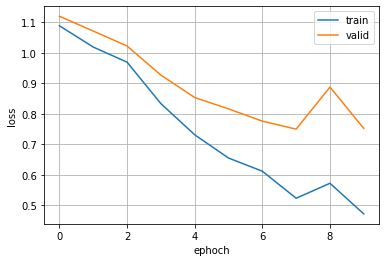

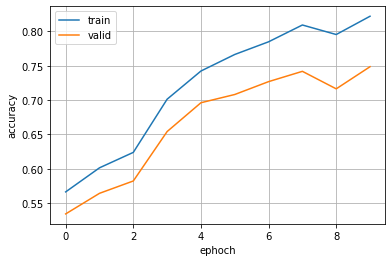

In [ ]:
plot(history['train_loss_values'], history['valid_loss_values'], NUM_EPOCHS, 'train', 'valid', 'ephoch', 'loss')
plot(history['train_accuracy_values'], history['valid_accuracy_values'], NUM_EPOCHS, 'train', 'valid', 'ephoch', 'accuracy')

結果として、学習データの正答率 : 0.8219, 検証データの正答率：0.7485 であった。  
実行時間に注目すると、約7.5分ほどであり、前回の単層/多層ニューラルネットの学習と比べるとかなり時間がかかっている。  
時間がかかった理由としては、`toID()`において`pd.DataFrame`型の`word2id`を参照してテキスト→IDの変換を行っているのだが、この`DataFrame`内で単語を探索する際に動作が重くなっていると考察される。  
テストとして、`dataset_train`の単語全てを`toID()`によってIDへ変換する際の時間を計測してみる。`toID()`は`dataset`における`__getitem__`内で使用されている。  
したがって、`loader_train`の要素を参照する際に実行される。

In [ ]:
loader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
start_time = time.time()
for inputs,labels in loader_train:
  id = inputs
end_time = time.time()
take_time = end_time - start_time

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


In [ ]:
take_time

171.49527072906494

結果は170秒であった。問題となっている`toID()`関数が使用される`for inputs,labels in loader_train:`の箇所は、`training`関数と`loss_accuracy_score`関数の二箇所である。つまり、テキスト→IDの処理でおよそ340秒かかっていることになる。  
このことから、動作が重い原因は`toID()`において`pd.DataFrame`型の`word2id`が原因であることがわかった。  
解決策として、`word2id`を`pd.DataFrame`型ではなく`dict`型にすることが考えられる。

なぜ`dict`型かという理由は以下のサイトを参考にした。  
[【Python】検索の速度なら、配列よりも辞書が優秀という話](https://www.m-coelacanth.com/entry/2019/04/28/133247)  
どうやら`dict`型の場合、keyで検索するときに、keyを元に生成されたハッシュ値で検索しているらしい。したがって、`pd.DataFrame`型のように中身を探索しにいってしまうのと比べると、速度が向上すると考察される。


`word2id`を`dict`型へ変更した後の実行速度を以下に示す。

In [ ]:
loader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
start_time = time.time()
for inputs,labels in loader_train:
  id = inputs
end_time = time.time()
take_time = end_time - start_time

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


In [ ]:
take_time

0.55942702293396

`dict`型を使用することによって`toID()`の処理(単語からIDに変換する処理)が170秒から0.55秒と爆速になった。

リファクタリング後の学習結果を以下に示す。

In [ ]:
# パラメータの設定
VOCAB_SIZE = len(word2id) + 1
EMB_SIZE = 300
PADDING_IDX = len(word2id)
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 1
NUM_EPOCHS = 10

device = torch.device('cpu')

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, device=device)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

## エポック数
NUM_EPOCHS = 10
## バッチサイズ
BATCH_SIZE = 1

history = training(model, dataset_train, dataset_valid, BATCH_SIZE, criterion, optimizer, NUM_EPOCHS)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


エポック数 : 1, 所要時間 : 72.295sec, 学習データの平均損失 : 1.0851, 検証データの損失1.1139
学習データの正答率 : 0.5502, 検証データの正答率0.5210

エポック数 : 2, 所要時間 : 70.356sec, 学習データの平均損失 : 1.0301, 検証データの損失1.0732
学習データの正答率 : 0.5918, 検証データの正答率0.5689

エポック数 : 3, 所要時間 : 71.993sec, 学習データの平均損失 : 0.9547, 検証データの損失1.0121
学習データの正答率 : 0.6480, 検証データの正答率0.6250

エポック数 : 4, 所要時間 : 69.310sec, 学習データの平均損失 : 0.8501, 検証データの損失0.9157
学習データの正答率 : 0.6854, 検証データの正答率0.6729

エポック数 : 5, 所要時間 : 68.417sec, 学習データの平均損失 : 0.7283, 検証データの損失0.8512
学習データの正答率 : 0.7435, 検証データの正答率0.7058

エポック数 : 6, 所要時間 : 67.033sec, 学習データの平均損失 : 0.6494, 検証データの損失0.8040
学習データの正答率 : 0.7687, 検証データの正答率0.7156

エポック数 : 7, 所要時間 : 66.606sec, 学習データの平均損失 : 0.5637, 検証データの損失0.7657
学習データの正答率 : 0.7937, 検証データの正答率0.7358

エポック数 : 8, 所要時間 : 67.129sec, 学習データの平均損失 : 0.5085, 検証データの損失0.7318
学習データの正答率 : 0.8134, 検証データの正答率0.7493

エポック数 : 9, 所要時間 : 66.747sec, 学習データの平均損失 : 0.4882, 検証データの損失0.7476
学習データの正答率 : 0.8145, 検証データの正答率0.7418

エポック数 : 10, 所要時間 : 67.218sec, 学習データの平均損失 : 0.4197, 検証データの損失0.7349
学習データの正答率 : 0.83

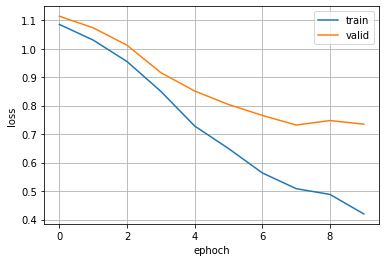

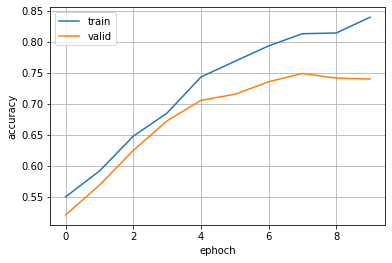

In [ ]:
plot(history['train_loss_values'], history['valid_loss_values'], NUM_EPOCHS, 'train', 'valid', 'ephoch', 'loss')
plot(history['train_accuracy_values'], history['valid_accuracy_values'], NUM_EPOCHS, 'train', 'valid', 'ephoch', 'accuracy')

ephoch=10での最終的な精度は0．75くらい．  
もう少しepoch数を増やしたら精度向上するかも

In [ ]:
# パラメータの設定
VOCAB_SIZE = len(word2id) + 1
EMB_SIZE = 300
PADDING_IDX = len(word2id)
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 1
NUM_EPOCHS = 10

device = torch.device('cpu')

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, device=device)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

## エポック数
NUM_EPOCHS = 30
## バッチサイズ
BATCH_SIZE = 1

history = training(model, dataset_train, dataset_valid, BATCH_SIZE, criterion, optimizer, NUM_EPOCHS)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


エポック数 : 1, 所要時間 : 78.352sec, 学習データの平均損失 : 1.0874, 検証データの損失1.1321
学習データの正答率 : 0.5555, 検証データの正答率0.5269

エポック数 : 2, 所要時間 : 78.960sec, 学習データの平均損失 : 1.0138, 検証データの損失1.0708
学習データの正答率 : 0.6013, 検証データの正答率0.5719

エポック数 : 3, 所要時間 : 77.923sec, 学習データの平均損失 : 0.9285, 検証データの損失0.9985
学習データの正答率 : 0.6494, 検証データの正答率0.6115

エポック数 : 4, 所要時間 : 78.493sec, 学習データの平均損失 : 0.8291, 検証データの損失0.9488
学習データの正答率 : 0.7041, 検証データの正答率0.6527

エポック数 : 5, 所要時間 : 78.711sec, 学習データの平均損失 : 0.7514, 検証データの損失0.9002
学習データの正答率 : 0.7275, 検証データの正答率0.6781

エポック数 : 6, 所要時間 : 77.919sec, 学習データの平均損失 : 0.6462, 検証データの損失0.7867
学習データの正答率 : 0.7685, 検証データの正答率0.7358

エポック数 : 7, 所要時間 : 77.828sec, 学習データの平均損失 : 0.5662, 検証データの損失0.7648
学習データの正答率 : 0.7903, 検証データの正答率0.7433

エポック数 : 8, 所要時間 : 77.805sec, 学習データの平均損失 : 0.6493, 検証データの損失0.8582
学習データの正答率 : 0.7563, 検証データの正答率0.6916

エポック数 : 9, 所要時間 : 75.257sec, 学習データの平均損失 : 0.5254, 検証データの損失0.7616
学習データの正答率 : 0.8122, 検証データの正答率0.7328

エポック数 : 10, 所要時間 : 79.179sec, 学習データの平均損失 : 0.4636, 検証データの損失0.7674
学習データの正答率 : 0.82

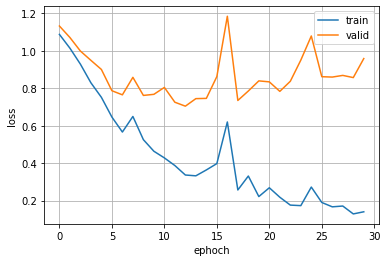

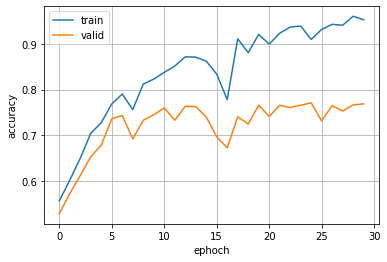

In [ ]:
plot(history['train_loss_values'], history['valid_loss_values'], NUM_EPOCHS, 'train', 'valid', 'ephoch', 'loss')
plot(history['train_accuracy_values'], history['valid_accuracy_values'], NUM_EPOCHS, 'train', 'valid', 'ephoch', 'accuracy')

エポック数 : 30, 所要時間 : 76.088sec, 学習データの平均損失 : 0.1404, 検証データの損失0.9584  
学習データの正答率 : 0.9536, 検証データの正答率0.7687  

エポック数を増やすと順調にTrainの損失は小さくなって，Trainの精度も95%ほどになっているが，Validのほうは，精度が0.76ほどになっていて，エポック数=10のとき(精度0.75ほど)とあまり変わらない結果となった．

## 83. ミニバッチ化・GPU上での学習

問題82のコードを改変し，B事例ごとに損失・勾配を計算して学習を行えるようにせよ（Bの値は適当に選べ）．また，GPU上で学習を実行せよ．



`training()`と`loss_accuracy_score()`に引数deviceを追加してGPU対応した。

ミニバッチとしてまとめるためには、系列長を揃える必要がある。  
そこで、複数の文の最大系列長に合わせてパディングする機能を持つ`Padsequence`クラスを作成する。  
この関数を`Dataloader`の引数`collate_fn`に与えることで、ミニバッチを取り出すごとに系列長を揃えることができる。  
以下`collate_fn`の参考サイト  
[Pytorchのcollate_fnを使ってみる](https://qiita.com/tomp/items/f220bd6ffec006dabaa5) 



パディング処理は`Pytorch`が持つ`torch.nn.utils.rnn.pad_sequence`関数を使用すれば簡単に作成することができる。  
以下`torch.nn.utils.rnn.pad_sequence`の参考サイト  
[PyTorchのシーケンスのpaddingとpackingを使い分ける](https://qiita.com/iBotamon/items/acffef7852faadb420fd)  
テストとして、`torch.nn.utils.rnn.pad_sequence`を試しに使ってみる。

In [ ]:
import torch.nn.utils.rnn as rnn

In [ ]:
a = torch.ones(1, 5)   #1単語
b = torch.ones(2, 5)*2 #2単語
c = torch.ones(3, 5)*3 #3単語とみなしている
print(f'{[a,b,c]}\n')
print(rnn.pad_sequence([a,b,c], batch_first=True))

[tensor([[1., 1., 1., 1., 1.]]), tensor([[2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.]]), tensor([[3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3.]])]

tensor([[[1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2.],
         [0., 0., 0., 0., 0.]],

        [[3., 3., 3., 3., 3.],
         [3., 3., 3., 3., 3.],
         [3., 3., 3., 3., 3.]]])


```
tensor([[[1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2.],
         [0., 0., 0., 0., 0.]],

        [[3., 3., 3., 3., 3.],
         [3., 3., 3., 3., 3.],
         [3., 3., 3., 3., 3.]]])
```
この塊をミニバッチとみなす

系列長が0パディングで揃っていることが確認できる。`Padsequence`クラスでは、引数の`padding_idx`の値でパディングする。

In [ ]:
import torch.nn.utils.rnn as rnn

class Padsequence:
  def __init__(self, padding_idx):
    ## padding_idx (=最大系列長の値)でパッディングする
    self.padding_idx = padding_idx
  
  def __call__(self, batch):
    ## 降順ソート
    sorted_batch = sorted(batch, key=lambda x:x[0].shape[0], reverse=True)
    sequences = [x[0] for x in sorted_batch]
    ## rnn.pad_sequenceを使用
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=self.padding_idx)    
    labels = torch.tensor([x[1] for x in sorted_batch])
    
    return sequences_padded, labels


In [ ]:
def loss_accuracy_score(model, dataset, criterion, device=None):
  dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
  model.eval()
  total = 0
  correct = 0
  loss = 0

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloader):
      ## 順伝播
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      
      ## 損失計算 
      loss += criterion(outputs, labels).item()

      ## 正答率計算
      pred = torch.argmax(outputs, dim=-1) #予測値算出
      correct += (pred == labels).sum().item() #正解判定
      total += len(inputs)
    
    loss /= i 
    accuracy = correct / total

  return loss, accuracy

In [ ]:
def training(model, dataset_train, dataset_valid, batch_size, criterion, optimizer, epochs, collate_fn=None, device=None): ##ここのcollate_fnにPadsequenceを渡している
  ## デバイス指定
  model.to(device)
  
  ## 指定したbatch_sizeで読み込み
  loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)  ##ここのcollate_fnにPadsequenceを渡している
  loader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)
  
  ## 記録変数historyを定義
  history = {}
  history['train_loss_values'] = []
  history['train_accuracy_values'] = []
  history['valid_loss_values'] = []
  history['valid_accuracy_values'] = []
  history['time'] = []

  ## 学習
  for epoch in range(epochs):
    start_time = time.time()
    model.train() #訓練モード

    for inputs,labels in loader_train:
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad() # 勾配ゼロ初期化
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    ## 以下評価モード
    model.eval()
    loss_train, acc_train = loss_accuracy_score(model, dataset_train, criterion, device)
    loss_valid, acc_valid = loss_accuracy_score(model, dataset_valid, criterion, device)
    history['train_loss_values'].append(loss_train)
    history['train_accuracy_values'].append(acc_train)
    history['valid_loss_values'].append(loss_valid)
    history['valid_accuracy_values'].append(acc_valid)
    
    #torch.save({'epoch':epoch, 'model_state_dict':model.state_dict(), 'optimizer_state_dict':optimizer.state_dict()}
    #          ,f'checkpoint{epoch+1}.pt')

    end_time = time.time()
    take_time = end_time - start_time
    history['time'].append(take_time)

    ## ログ出力
    print(f'エポック数 : {epoch+1}, 所要時間 : {take_time:.3f}sec, 学習データの平均損失 : {loss_train:.4f}, 検証データの損失{loss_valid:.4f}') 
    print(f'学習データの正答率 : {acc_train:.4f}, 検証データの正答率{acc_valid:.4f}\n') 

  return history

バッチサイズは32とした。  

In [ ]:
# パラメータの設定
VOCAB_SIZE = len(word2id) + 1
EMB_SIZE = 300
## padding_idx (=最大系列長の値)でパッディングする
PADDING_IDX = len(word2id)
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 1e-3

# デバイス指定
device = torch.device('cuda')

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, device=device)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

## エポック数
NUM_EPOCHS = 10
## バッチサイズ
BATCH_SIZE = 32
##　バッチサイズで1でやってみておなじになるか確かめるなど

history = training(model, dataset_train, dataset_valid, BATCH_SIZE, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


エポック数 : 1, 所要時間 : 9.415sec, 学習データの平均損失 : 1.4104, 検証データの損失1.4107
学習データの正答率 : 0.3387, 検証データの正答率0.3316

エポック数 : 2, 所要時間 : 9.402sec, 学習データの平均損失 : 1.3426, 検証データの損失1.3462
学習データの正答率 : 0.3788, 検証データの正答率0.3683

エポック数 : 3, 所要時間 : 9.256sec, 学習データの平均損失 : 1.3114, 検証データの損失1.3199
学習データの正答率 : 0.3925, 検証データの正答率0.3885

エポック数 : 4, 所要時間 : 9.276sec, 学習データの平均損失 : 1.3014, 検証データの損失1.3147
学習データの正答率 : 0.3995, 検証データの正答率0.3952

エポック数 : 5, 所要時間 : 9.256sec, 学習データの平均損失 : 1.3006, 検証データの損失1.3185
学習データの正答率 : 0.4025, 検証データの正答率0.3997

エポック数 : 6, 所要時間 : 9.325sec, 学習データの平均損失 : 1.3043, 検証データの損失1.3259
学習データの正答率 : 0.4035, 検証データの正答率0.4004

エポック数 : 7, 所要時間 : 9.327sec, 学習データの平均損失 : 1.3102, 検証データの損失1.3354
学習データの正答率 : 0.4015, 検証データの正答率0.4004

エポック数 : 8, 所要時間 : 9.416sec, 学習データの平均損失 : 1.3169, 検証データの損失1.3453
学習データの正答率 : 0.4001, 検証データの正答率0.3967

エポック数 : 9, 所要時間 : 9.336sec, 学習データの平均損失 : 1.3237, 検証データの損失1.3543
学習データの正答率 : 0.3984, 検証データの正答率0.3952

エポック数 : 10, 所要時間 : 9.349sec, 学習データの平均損失 : 1.3294, 検証データの損失1.3624
学習データの正答率 : 0.3977, 検証データの

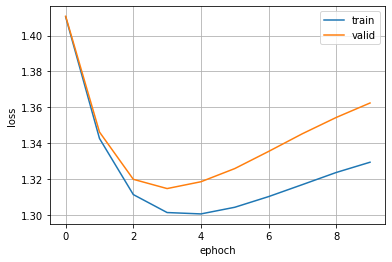

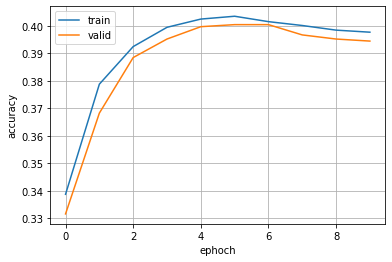

In [ ]:
plot(history['train_loss_values'], history['valid_loss_values'], NUM_EPOCHS, 'train', 'valid', 'ephoch', 'loss')
plot(history['train_accuracy_values'], history['valid_accuracy_values'], NUM_EPOCHS, 'train', 'valid', 'ephoch', 'accuracy')

In [ ]:
print(f"正解率（学習データ）：{history['train_accuracy_values'][-1]:.3f}")
print(f"正解率（評価データ）：{history['valid_accuracy_values'][-1]:.3f}")

正解率（学習データ）：0.398
正解率（評価データ）：0.394


おそらくここも，epoch=10ではepoch数が足りない感じがする．  
その理由は，損失が収束せずに，増減しているため．  
epoch=30で回してみる

In [ ]:
# パラメータの設定
VOCAB_SIZE = len(word2id) + 1
EMB_SIZE = 300
PADDING_IDX = len(word2id)
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 1e-3

# デバイス指定
device = torch.device('cuda')

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, device=device)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

## エポック数
NUM_EPOCHS = 30
## バッチサイズ
BATCH_SIZE = 32

history = training(model, dataset_train, dataset_valid, BATCH_SIZE, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


エポック数 : 1, 所要時間 : 9.136sec, 学習データの平均損失 : 1.3167, 検証データの損失1.3179
学習データの正答率 : 0.4018, 検証データの正答率0.3855

エポック数 : 2, 所要時間 : 9.111sec, 学習データの平均損失 : 1.2785, 検証データの損失1.2828
学習データの正答率 : 0.4137, 検証データの正答率0.3937

エポック数 : 3, 所要時間 : 9.218sec, 学習データの平均損失 : 1.2636, 検証データの損失1.2715
学習データの正答率 : 0.4205, 検証データの正答率0.3982

エポック数 : 4, 所要時間 : 9.197sec, 学習データの平均損失 : 1.2581, 検証データの損失1.2695
学習データの正答率 : 0.4232, 検証データの正答率0.4004

エポック数 : 5, 所要時間 : 9.146sec, 学習データの平均損失 : 1.2576, 検証データの損失1.2728
学習データの正答率 : 0.4267, 検証データの正答率0.4034

エポック数 : 6, 所要時間 : 9.122sec, 学習データの平均損失 : 1.2571, 検証データの損失1.2748
学習データの正答率 : 0.4276, 検証データの正答率0.4049

エポック数 : 7, 所要時間 : 9.107sec, 学習データの平均損失 : 1.2587, 検証データの損失1.2794
学習データの正答率 : 0.4284, 検証データの正答率0.4027

エポック数 : 8, 所要時間 : 9.080sec, 学習データの平均損失 : 1.2613, 検証データの損失1.2847
学習データの正答率 : 0.4270, 検証データの正答率0.4019

エポック数 : 9, 所要時間 : 9.112sec, 学習データの平均損失 : 1.2656, 検証データの損失1.2920
学習データの正答率 : 0.4276, 検証データの正答率0.3990

エポック数 : 10, 所要時間 : 9.159sec, 学習データの平均損失 : 1.2686, 検証データの損失1.2971
学習データの正答率 : 0.4275, 検証データの

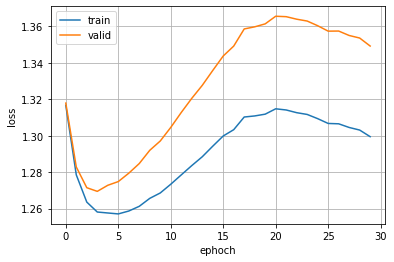

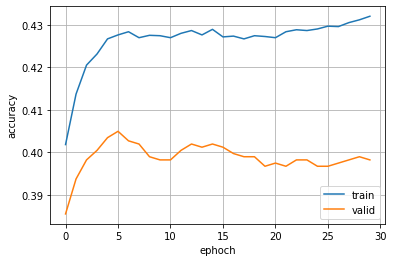

In [ ]:
plot(history['train_loss_values'], history['valid_loss_values'], NUM_EPOCHS, 'train', 'valid', 'ephoch', 'loss')
plot(history['train_accuracy_values'], history['valid_accuracy_values'], NUM_EPOCHS, 'train', 'valid', 'ephoch', 'accuracy')

In [ ]:
print(f"正解率（学習データ）：{history['train_accuracy_values'][-1]:.3f}")
print(f"正解率（評価データ）：{history['valid_accuracy_values'][-1]:.3f}")

正解率（学習データ）：0.432
正解率（評価データ）：0.398


ミニバッチだとよろしくない OR 隠れ層のサイズが50だと小さいので不十分説ある．

隠れ層のサイズを100くらいにしてエポック数は30でやってみる

In [ ]:
# パラメータの設定
VOCAB_SIZE = len(word2id) + 1
EMB_SIZE = 300
PADDING_IDX = len(word2id)
OUTPUT_SIZE = 4
HIDDEN_SIZE = 100
LEARNING_RATE = 1e-3

# デバイス指定
device = torch.device('cuda')

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, device=device)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

## エポック数
NUM_EPOCHS = 30
## バッチサイズ
BATCH_SIZE = 32

history = training(model, dataset_train, dataset_valid, BATCH_SIZE, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


エポック数 : 1, 所要時間 : 11.330sec, 学習データの平均損失 : 1.2963, 検証データの損失1.3037
学習データの正答率 : 0.3925, 検証データの正答率0.3877

エポック数 : 2, 所要時間 : 9.286sec, 学習データの平均損失 : 1.2612, 検証データの損失1.2781
学習データの正答率 : 0.4155, 検証データの正答率0.3975

エポック数 : 3, 所要時間 : 9.190sec, 学習データの平均損失 : 1.2482, 検証データの損失1.2731
学習データの正答率 : 0.4264, 検証データの正答率0.4072

エポック数 : 4, 所要時間 : 9.331sec, 学習データの平均損失 : 1.2411, 検証データの損失1.2701
学習データの正答率 : 0.4335, 検証データの正答率0.4184

エポック数 : 5, 所要時間 : 9.229sec, 学習データの平均損失 : 1.2408, 検証データの損失1.2741
学習データの正答率 : 0.4349, 検証データの正答率0.4192

エポック数 : 6, 所要時間 : 9.266sec, 学習データの平均損失 : 1.2448, 検証データの損失1.2827
学習データの正答率 : 0.4374, 検証データの正答率0.4199

エポック数 : 7, 所要時間 : 9.302sec, 学習データの平均損失 : 1.2509, 検証データの損失1.2928
学習データの正答率 : 0.4367, 検証データの正答率0.4192

エポック数 : 8, 所要時間 : 9.274sec, 学習データの平均損失 : 1.2571, 検証データの損失1.3017
学習データの正答率 : 0.4354, 検証データの正答率0.4199

エポック数 : 9, 所要時間 : 9.263sec, 学習データの平均損失 : 1.2610, 検証データの損失1.3068
学習データの正答率 : 0.4347, 検証データの正答率0.4199

エポック数 : 10, 所要時間 : 9.627sec, 学習データの平均損失 : 1.2666, 検証データの損失1.3145
学習データの正答率 : 0.4343, 検証データ

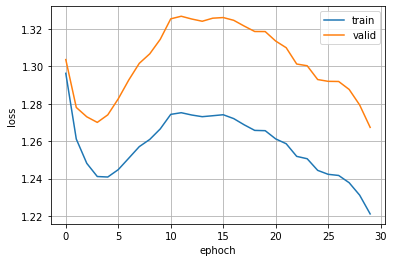

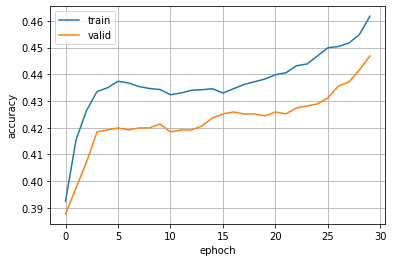

正解率（学習データ）：0.462
正解率（評価データ）：0.447


In [ ]:
plot(history['train_loss_values'], history['valid_loss_values'], NUM_EPOCHS, 'train', 'valid', 'ephoch', 'loss')
plot(history['train_accuracy_values'], history['valid_accuracy_values'], NUM_EPOCHS, 'train', 'valid', 'ephoch', 'accuracy')
print(f"正解率（学習データ）：{history['train_accuracy_values'][-1]:.3f}")
print(f"正解率（評価データ）：{history['valid_accuracy_values'][-1]:.3f}")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


エポック数 : 1, 所要時間 : 9.985sec, 学習データの平均損失 : 1.3359, 検証データの損失1.3369
学習データの正答率 : 0.3860, 検証データの正答率0.3795

エポック数 : 2, 所要時間 : 9.371sec, 学習データの平均損失 : 1.2738, 検証データの損失1.2838
学習データの正答率 : 0.4078, 検証データの正答率0.4087

エポック数 : 3, 所要時間 : 9.423sec, 学習データの平均損失 : 1.2535, 検証データの損失1.2709
学習データの正答率 : 0.4221, 検証データの正答率0.4177

エポック数 : 4, 所要時間 : 9.557sec, 学習データの平均損失 : 1.2494, 検証データの損失1.2735
学習データの正答率 : 0.4288, 検証データの正答率0.4222

エポック数 : 5, 所要時間 : 9.714sec, 学習データの平均損失 : 1.2514, 検証データの損失1.2802
学習データの正答率 : 0.4292, 検証データの正答率0.4237

エポック数 : 6, 所要時間 : 9.416sec, 学習データの平均損失 : 1.2582, 検証データの損失1.2923
学習データの正答率 : 0.4291, 検証データの正答率0.4192

エポック数 : 7, 所要時間 : 10.107sec, 学習データの平均損失 : 1.2650, 検証データの損失1.3026
学習データの正答率 : 0.4272, 検証データの正答率0.4177

エポック数 : 8, 所要時間 : 9.715sec, 学習データの平均損失 : 1.2736, 検証データの損失1.3150
学習データの正答率 : 0.4254, 検証データの正答率0.4154

エポック数 : 9, 所要時間 : 9.660sec, 学習データの平均損失 : 1.2812, 検証データの損失1.3256
学習データの正答率 : 0.4250, 検証データの正答率0.4139

エポック数 : 10, 所要時間 : 9.332sec, 学習データの平均損失 : 1.2860, 検証データの損失1.3320
学習データの正答率 : 0.4236, 検証データ

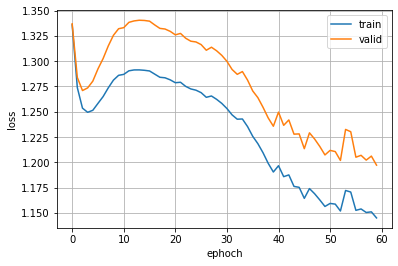

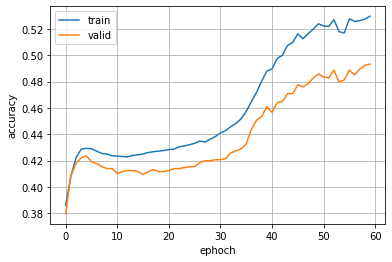

正解率（学習データ）：0.530
正解率（評価データ）：0.493


In [ ]:
# パラメータの設定
VOCAB_SIZE = len(word2id) + 1
EMB_SIZE = 300
PADDING_IDX = len(word2id)
OUTPUT_SIZE = 4
HIDDEN_SIZE = 100
LEARNING_RATE = 1e-3

# デバイス指定
device = torch.device('cuda')

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, device=device)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

## エポック数
NUM_EPOCHS = 60
## バッチサイズ
BATCH_SIZE = 32

history = training(model, dataset_train, dataset_valid, BATCH_SIZE, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)
plot(history['train_loss_values'], history['valid_loss_values'], NUM_EPOCHS, 'train', 'valid', 'ephoch', 'loss')
plot(history['train_accuracy_values'], history['valid_accuracy_values'], NUM_EPOCHS, 'train', 'valid', 'ephoch', 'accuracy')
print(f"正解率（学習データ）：{history['train_accuracy_values'][-1]:.3f}")
print(f"正解率（評価データ）：{history['valid_accuracy_values'][-1]:.3f}")


まだエポック数が足りないかも
validとTrainがエポック数を増やすと離れていく
その過学習の直前くらいまでエポック数を増やすと良い

## 84. 単語ベクトルの導入
事前学習済みの単語ベクトル（例えば，Google Newsデータセット（約1,000億単語）での学習済み単語ベクトル）で単語埋め込み$emb(x)$を初期化し，学習せよ．


前章と同様に事前学習済み単語ベクトルをダウンロードする。


In [ ]:
# 学習済み単語ベクトルのダウンロード
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-07-13 13:47:44--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.138.88
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.138.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  36.8MB/s    in 45s     

2021-07-13 13:48:30 (34.6 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



事前学習済み単語ベクトルをモデルに利用する場合、その単語をすべて利用する方法（辞書を置き換える方法）と、手元のデータの辞書はそのまま利用し、それらの単語ベクトルの初期値としてのみ利用する方法がある。
今回は後者の方法を採用し、すでに作成している辞書に対応する単語ベクトルを抽出する。

In [ ]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'

In [ ]:
from gensim.models import KeyedVectors

word2vec_model = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)


In [ ]:
## 学習済み単語ベクトルの作成
VOCAB_SIZE = len(word2id.values()) + 1
EMB_SIZE = 300
weight = np.zeros((VOCAB_SIZE, EMB_SIZE))
pretrained_cnt = 0

for i, word in enumerate(word2id.keys()):
  try:
    ## key(=word)に対応する単語ベクトルを取得する
    weight[i] = word2vec_model[word]
    pretrained_cnt += 1
  ## もし，単語ベクトルに存在しない単語であれば，ランダムなベクトルを割り当てる．
  except KeyError:
    weight[i] = np.random.normal(scale=0.4, size=(EMB_SIZE,))
weight = torch.from_numpy(weight.astype((np.float32)))

print(f'学習済みベクトル利用単語数：{pretrained_cnt} / {VOCAB_SIZE}')
print(weight.size())
print(weight)

学習済みベクトル利用単語数：9174 / 9406
torch.Size([9406, 300])
tensor([[-0.0818,  0.6410,  0.1436,  ...,  0.3170, -0.6858, -0.4281],
        [-0.2910,  0.1787,  0.0500,  ..., -0.0228,  0.1177,  0.3535],
        [ 0.0703,  0.0869,  0.0879,  ..., -0.0476,  0.0145, -0.0625],
        ...,
        [-0.1709, -0.0371, -0.1484,  ...,  0.4824,  0.0273,  0.0028],
        [-0.0459,  0.2041,  0.0464,  ..., -0.0137,  0.3574, -0.0168],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


ネットワークの埋め込み層に初期値`emb_weights`を設定できるように変更する。  
`Pytorch`の`nn.Embedding.from_pretrained`を用いて事前学習済みの単語ベクトルを読み込む。  
[Pytorch 公式ライブラリ　nn.Embadding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding.from_pretrained)

In [ ]:
class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size, emb_weights=None, device=None):
    super().__init__()
    self.hidden_size = hidden_size
    if emb_weights == None:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    else:
      ##ネットワークの埋め込み層に引数の初期値emb_weightsを設定
      self.emb = nn.Embedding.from_pretrained(emb_weights) 
    self.rnn = nn.RNN(emb_size, hidden_size, nonlinearity='tanh', batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
  
  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden()
    emb = self.emb(x)
    output, hidden = self.rnn(emb, hidden)
    output = self.fc(output[:, -1, :])
    return output

  def init_hidden(self):
    hidden = torch.zeros(1, self.batch_size, self.hidden_size).to(device)
    return hidden

In [ ]:
# パラメータの設定
VOCAB_SIZE = len(word2id) + 1
EMB_SIZE = 300
PADDING_IDX = len(word2id)
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 1e-3
NUM_EPOCHS = 10

# デバイス指定
device = torch.device('cuda')

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, emb_weights=weight, device=device)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

## エポック数
NUM_EPOCHS = 10
## バッチサイズ
BATCH_SIZE = 32

history = training(model, dataset_train, dataset_valid, BATCH_SIZE, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


エポック数 : 1, 所要時間 : 9.280sec, 学習データの平均損失 : 1.4172, 検証データの損失1.4254
学習データの正答率 : 0.2590, 検証データの正答率0.2343

エポック数 : 2, 所要時間 : 9.222sec, 学習データの平均損失 : 1.2994, 検証データの損失1.3054
学習データの正答率 : 0.3305, 検証データの正答率0.3286

エポック数 : 3, 所要時間 : 9.261sec, 学習データの平均損失 : 1.2221, 検証データの損失1.2276
学習データの正答率 : 0.4680, 検証データの正答率0.4633

エポック数 : 4, 所要時間 : 9.305sec, 学習データの平均損失 : 1.1808, 検証データの損失1.1876
学習データの正答率 : 0.4863, 検証データの正答率0.4693

エポック数 : 5, 所要時間 : 9.335sec, 学習データの平均損失 : 1.1604, 検証データの損失1.1694
学習データの正答率 : 0.4815, 検証データの正答率0.4626

エポック数 : 6, 所要時間 : 9.358sec, 学習データの平均損失 : 1.1500, 検証データの損失1.1619
学習データの正答率 : 0.4784, 検証データの正答率0.4573

エポック数 : 7, 所要時間 : 9.402sec, 学習データの平均損失 : 1.1460, 検証データの損失1.1614
学習データの正答率 : 0.4745, 検証データの正答率0.4446

エポック数 : 8, 所要時間 : 9.240sec, 学習データの平均損失 : 1.1450, 検証データの損失1.1641
学習データの正答率 : 0.4679, 検証データの正答率0.4371

エポック数 : 9, 所要時間 : 9.273sec, 学習データの平均損失 : 1.1463, 検証データの損失1.1689
学習データの正答率 : 0.4646, 検証データの正答率0.4349

エポック数 : 10, 所要時間 : 9.333sec, 学習データの平均損失 : 1.1496, 検証データの損失1.1759
学習データの正答率 : 0.4622, 検証データの

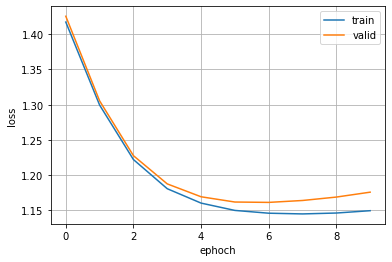

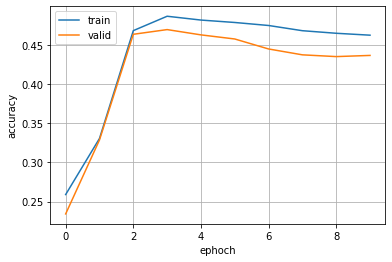

In [ ]:
plot(history['train_loss_values'], history['valid_loss_values'], NUM_EPOCHS, 'train', 'valid', 'ephoch', 'loss')
plot(history['train_accuracy_values'], history['valid_accuracy_values'], NUM_EPOCHS, 'train', 'valid', 'ephoch', 'accuracy')

In [ ]:
print(f"正解率（学習データ）：{history['train_accuracy_values'][-1]:.3f}")
print(f"正解率（評価データ）：{history['valid_accuracy_values'][-1]:.3f}")

正解率（学習データ）：0.462
正解率（評価データ）：0.436


## 85. 双方向RNN・多層化
順方向と逆方向のRNNの両方を用いて入力テキストをエンコードし，モデルを学習せよ．

$$
\overleftarrow h_{T+1} = 0, \\
\overleftarrow h_t = {\rm \overleftarrow{RNN}}(\mathrm{emb}(x_t), \overleftarrow h_{t+1}), \\
y = {\rm softmax}(W^{(yh)} [\overrightarrow h_T; \overleftarrow h_1] + b^{(y)})
$$

ただし，$\overrightarrow h_t \in \mathbb{R}^{d_h}, \overleftarrow h_t \in \mathbb{R}^{d_h}$はそれぞれ，順方向および逆方向のRNNで求めた時刻$t$の隠れ状態ベクトル，${\rm \overleftarrow{RNN}}(x,h)$は入力$x$と次時刻の隠れ状態$h$から前状態を計算するRNNユニット，$W^{(yh)} \in \mathbb{R}^{L \times 2d_h}$は隠れ状態ベクトルからカテゴリを予測するための行列，$b^{(y)} \in \mathbb{R}^{L}$はバイアス項である．また，$[a; b]$はベクトル$a$と$b$の連結を表す。

さらに，双方向RNNを多層化して実験せよ．


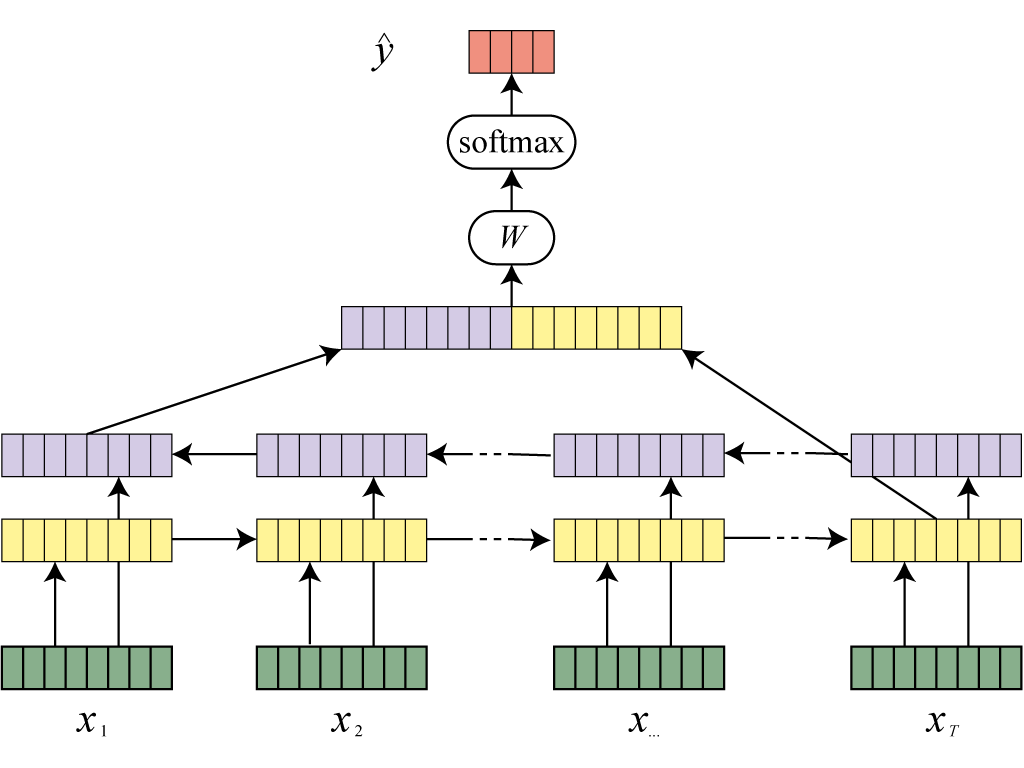

`Pytorch`の`torch.nn.RNN`のオプション  
`bidirecutional`を`True`にすれば双方向RNNとなる。  
また、`num_layers`を指定することで多層のRNNを組むことができる。

In [ ]:
class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size, num_layers, emb_weights=None, bidirectional=False, device=None):
    super().__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_directions = bidirectional + 1  #単方向：1、双方向：2
    if emb_weights == None:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding.from_pretrained(emb_weights)
    self.rnn = nn.RNN(emb_size, hidden_size, num_layers=num_layers, nonlinearity='tanh', batch_first=True, bidirectional=bidirectional)
    self.fc = nn.Linear(hidden_size * self.num_directions, output_size)
  
  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden()
    emb = self.emb(x)
    output, hidden = self.rnn(emb, hidden)
    output = self.fc(output[:, -1, :])
    return output

  def init_hidden(self):
    hidden = torch.zeros(self.num_layers * self.num_directions, self.batch_size, self.hidden_size).to(self.device)
    return hidden

[memo]  
単方向、双方向の数`num_directions`を考慮して`self.fc`の全結合層を`(hidden_size * self.num_directions, output_size)`にしないとエラーとなる。  
隠れ層`hidden`はレイヤーの数`num_layers`も考慮して、`torch.zeros(self.num_layers * self.num_directions, self.batch_size, self.hidden_size)`で初期化している。

In [ ]:
# パラメータの設定
VOCAB_SIZE = len(word2id) + 1
EMB_SIZE = 300
PADDING_IDX = len(word2id)
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 1e-3
NUM_EPOCHS = 10
NUM_LAYERS = 2

# デバイス指定
device = torch.device('cuda')

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weight, bidirectional=True, device=device)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

## エポック数
NUM_EPOCHS = 10
## バッチサイズ
BATCH_SIZE = 32

history = training(model, dataset_train, dataset_valid, BATCH_SIZE, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



エポック数 : 1, 所要時間 : 16.966sec, 学習データの平均損失 : 1.2409, 検証データの損失1.3136
学習データの正答率 : 0.4526, 検証データの正答率0.4356

エポック数 : 2, 所要時間 : 16.854sec, 学習データの平均損失 : 1.3133, 検証データの損失1.3714
学習データの正答率 : 0.4010, 検証データの正答率0.3975

エポック数 : 3, 所要時間 : 16.800sec, 学習データの平均損失 : 1.2931, 検証データの損失1.3895
学習データの正答率 : 0.4859, 検証データの正答率0.4611

エポック数 : 4, 所要時間 : 16.802sec, 学習データの平均損失 : 1.3059, 検証データの損失1.3590
学習データの正答率 : 0.4195, 検証データの正答率0.4139

エポック数 : 5, 所要時間 : 16.934sec, 学習データの平均損失 : 1.1903, 検証データの損失1.2634
学習データの正答率 : 0.5114, 検証データの正答率0.4843

エポック数 : 6, 所要時間 : 17.442sec, 学習データの平均損失 : 1.1406, 検証データの損失1.1839
学習データの正答率 : 0.5235, 検証データの正答率0.4993

エポック数 : 7, 所要時間 : 17.176sec, 学習データの平均損失 : 1.2583, 検証データの損失1.3373
学習データの正答率 : 0.5168, 検証データの正答率0.5007

エポック数 : 8, 所要時間 : 17.281sec, 学習データの平均損失 : 1.2246, 検証データの損失1.2858
学習データの正答率 : 0.4734, 検証データの正答率0.4513

エポック数 : 9, 所要時間 : 17.130sec, 学習データの平均損失 : 1.2461, 検証データの損失1.2889
学習データの正答率 : 0.4200, 検証データの正答率0.4184

エポック数 : 10, 所要時間 : 17.027sec, 学習データの平均損失 : 1.0878, 検証データの損失1.1497
学習データの正答率 : 0.58

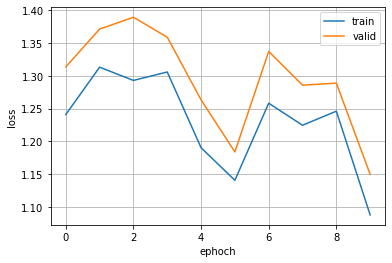

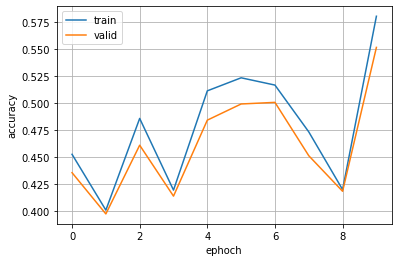

正解率（学習データ）：0.580
正解率（評価データ）：0.552


In [ ]:
plot(history['train_loss_values'], history['valid_loss_values'], NUM_EPOCHS, 'train', 'valid', 'ephoch', 'loss')
plot(history['train_accuracy_values'], history['valid_accuracy_values'], NUM_EPOCHS, 'train', 'valid', 'ephoch', 'accuracy')
print(f"正解率（学習データ）：{history['train_accuracy_values'][-1]:.3f}")
print(f"正解率（評価データ）：{history['valid_accuracy_values'][-1]:.3f}")

In [ ]:
## エポック数を30に変更
NUM_EPOCHS = 30

history = training(model, dataset_train, dataset_valid, BATCH_SIZE, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


エポック数 : 1, 所要時間 : 9.471sec, 学習データの平均損失 : 1.1540, 検証データの損失1.1843
学習データの正答率 : 0.4621, 検証データの正答率0.4349

エポック数 : 2, 所要時間 : 9.481sec, 学習データの平均損失 : 1.1605, 検証データの損失1.1949
学習データの正答率 : 0.4592, 検証データの正答率0.4379

エポック数 : 3, 所要時間 : 9.383sec, 学習データの平均損失 : 1.1702, 検証データの損失1.2088
学習データの正答率 : 0.4537, 検証データの正答率0.4266

エポック数 : 4, 所要時間 : 9.282sec, 学習データの平均損失 : 1.1812, 検証データの損失1.2240
学習データの正答率 : 0.4502, 検証データの正答率0.4274

エポック数 : 5, 所要時間 : 9.352sec, 学習データの平均損失 : 1.1920, 検証データの損失1.2391
学習データの正答率 : 0.4478, 検証データの正答率0.4304

エポック数 : 6, 所要時間 : 9.300sec, 学習データの平均損失 : 1.2024, 検証データの損失1.2529
学習データの正答率 : 0.4441, 検証データの正答率0.4296

エポック数 : 7, 所要時間 : 9.214sec, 学習データの平均損失 : 1.2154, 検証データの損失1.2696
学習データの正答率 : 0.4396, 検証データの正答率0.4304

エポック数 : 8, 所要時間 : 9.244sec, 学習データの平均損失 : 1.2278, 検証データの損失1.2850
学習データの正答率 : 0.4358, 検証データの正答率0.4244

エポック数 : 9, 所要時間 : 9.295sec, 学習データの平均損失 : 1.2339, 検証データの損失1.2933
学習データの正答率 : 0.4362, 検証データの正答率0.4259

エポック数 : 10, 所要時間 : 9.328sec, 学習データの平均損失 : 1.2452, 検証データの損失1.3072
学習データの正答率 : 0.4322, 検証データの

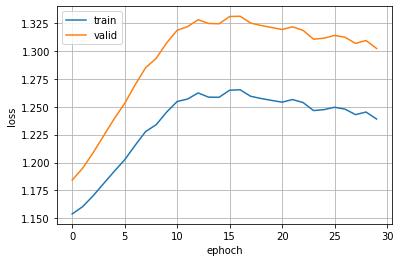

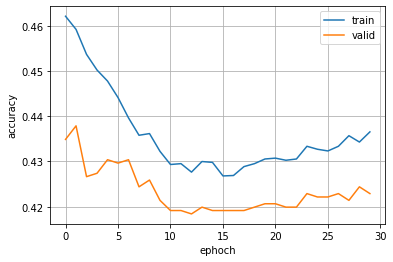

正解率（学習データ）：0.437
正解率（評価データ）：0.423


In [ ]:
plot(history['train_loss_values'], history['valid_loss_values'], NUM_EPOCHS, 'train', 'valid', 'ephoch', 'loss')
plot(history['train_accuracy_values'], history['valid_accuracy_values'], NUM_EPOCHS, 'train', 'valid', 'ephoch', 'accuracy')
print(f"正解率（学習データ）：{history['train_accuracy_values'][-1]:.3f}")
print(f"正解率（評価データ）：{history['valid_accuracy_values'][-1]:.3f}")

## 86. 畳み込みニューラルネットワーク (CNN)
ID番号で表現された単語列$\boldsymbol x = (x_1, x_2, \dots, x_T)$がある．ただし，$T$は単語列の長さ，$x_t \in \mathbb{R}^{V}$は単語のID番号のone-hot表記である（$V$は単語の総数である）．畳み込みニューラルネットワーク（CNN: Convolutional Neural Network）を用い，単語列$\boldsymbol x$からカテゴリ$y$を予測するモデルを実装せよ．

ただし，畳み込みニューラルネットワークの構成は以下の通りとする．

+ 単語埋め込みの次元数: $d_w$
+ 畳み込みのフィルターのサイズ: 3 トークン
+ 畳み込みのストライド: 1 トークン
+ 畳み込みのパディング: あり
+ 畳み込み演算後の各時刻のベクトルの次元数: $d_h$
+ 畳み込み演算後に最大値プーリング（max pooling）を適用し，入力文を$d_h$次元の隠れベクトルで表現
 すなわち，時刻$t$の特徴ベクトル$p_t \in \mathbb{R}^{d_h}$は次式で表される．

$$
p_t = g(W^{(px)} [\mathrm{emb}(x_{t-1}); \mathrm{emb}(x_t); \mathrm{emb}(x_{t+1})] + b^{(p)})
$$

ただし，$W^{(px)} \in \mathbb{R}^{d_h \times 3d_w}, b^{(p)} \in \mathbb{R}^{d_h}$はCNNのパラメータ，$g$は活性化関数（例えば$\tanh$やReLUなど），$[a; b; c]$はベクトル$a, b, c$の連結である．なお，行列$W^{(px)}$の列数が$3d_w$になるのは，3個のトークンの単語埋め込みを連結したものに対して，線形変換を行うためである．
最大値プーリングでは，特徴ベクトルの次元毎に全時刻における最大値を取り，入力文書の特徴ベクトル$c \in \mathbb{R}^{d_h}$を求める．$c[i]$でベクトル$c$の$i$番目の次元の値を表すことにすると，最大値プーリングは次式で表される．

$$
c[i] = \max_{1 \leq t \leq T} p_t[i]
$$

最後に，入力文書の特徴ベクトル$c$に行列$W^{(yc)} \in \mathbb{R}^{L \times d_h}$とバイアス項$b^{(y)} \in \mathbb{R}^{L}$による線形変換とソフトマックス関数を適用し，カテゴリ$y$を予測する．

$$
y = {\rm softmax}(W^{(yc)} c + b^{(y)})
$$

なお，この問題ではモデルの学習を行わず，ランダムに初期化された重み行列で$y$を計算するだけでよい．


そもそもCNNってどうやって言語処理で使うねん  
→わかりやすい記事があった  
https://tkengo.github.io/blog/2016/03/11/understanding-convolutional-neural-networks-for-nlp/

pytorchに用意してある，nn.Conv2dで畳み込みを計算する．  
https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html  

max_poolで系列長方向の中で最大値を取得する．  
ここの最大値によって文単位のベクトルを形成する．  

maxpoolingはpytorchのmax_pool1dを使う(1次元)  
第一引数はインプット，第二引数はシーケンスの長さ．  
https://pytorch.org/docs/stable/generated/torch.nn.functional.conv1d.html#torch.nn.functional.conv1d

次元の削減：squeeze関数  
squeezeは大きさが1である次元を削除する関数  
簡単に言うと、この余分な[]を取り除き、次元を減らす関数。  
https://jellyware.jp/kurage/openvino/c06_numpy.html

### CNNの得意・不得意
#### 得意
+ ざっくりとした分類問題
+　感情分類
+　カテゴリ分類
+　スパム検出 など
+ 畳み込みはGPU計算でいけるので，RNNと比べて計算が早い

#### 不得意
+ 単語の局所的な位置情報が重要なタスク
+　NER
+　品詞のタグ付け

conv1Dでできるかも

In [ ]:
from torch.nn import functional as F

class CNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights, stride, padding, emb_weights=None, device=None):
    super().__init__()
    if  emb_weights != None:
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    ## 畳み込み層を定義
    self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0)) 
    ## ドロップアウト
    self.drop = nn.Dropout(0.3)
    ## 全結合層
    self.fc = nn.Linear(out_channels, output_size)

  def forward(self, x):
    ## xのサイズは，(batch_size, Sequence_len)
    emb = self.emb(x).unsqueeze(1) #列ベクトル，次元を増やす
    ## embのサイズは， (batch_size, 1, seq_len, emb_size)
    conv = self.conv(emb)
    ## convのサイズは，(batch_size, out_channels, seq_len, 1)
    active = F.relu(conv.squeeze(3)) #ここのsqueeze(3)とは？→# dim = 3のみ次元を削減する
    ## activeのサイズは，(batch_size, out_channels, seq_len)
    #print(f'active.size() = {active.size()}')
    max_pool = F.max_pool1d(active, active.size()[2])
    ## max_poolのサイズは，(batch_size, out_channels, 1) 
    ## seq_len方向に最大値を取得する
    output = self.fc(self.drop(max_pool.squeeze(2)))  #ここのsqueeze(2)とは？→# dim = 2のみ次元を削減する
    ## outputのサイズは，(batch_size, output_size)
    return output    


In [ ]:
# 次元を削減 squeeze()
a = torch.zeros(2,1,3,1)
print(a)

b = torch.squeeze(a).size()
print(b)
print(torch.squeeze(a))

c = torch.squeeze(a, 1).size() # dim = 1のみsqueeze
print(c)
print(torch.squeeze(a, 1))
print(a.squeeze(1))


tensor([[[[0.],
          [0.],
          [0.]]],


        [[[0.],
          [0.],
          [0.]]]])
torch.Size([2, 3])
tensor([[0., 0., 0.],
        [0., 0., 0.]])
torch.Size([2, 3, 1])
tensor([[[0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]]])
tensor([[[0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]]])


In [ ]:
# 次元を増やす unsqueeze()
b = torch.zeros(2,3,4)
d = torch.unsqueeze(b,0).size() # unsqueeze(tensor,dim)
print(d)

torch.Size([1, 2, 3, 4])


In [ ]:
## パラメータ設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100 ##畳み込みによって生成されたチャネルの数
KERNEL_HEIGHTS = 3 ##フィルタの大きさ
STRIDE = 1 ##ストライド
PADDING = 1 ##入力にパディングするかどうか　1なのでパディングする

# モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weight)

# 先頭10件の予測値取得
for i in range(10):
  X,y = dataset_train[i]
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.2796, 0.2440, 0.2468, 0.2296]], grad_fn=<SoftmaxBackward>)
tensor([[0.2352, 0.2590, 0.2621, 0.2437]], grad_fn=<SoftmaxBackward>)
tensor([[0.2342, 0.2751, 0.2508, 0.2398]], grad_fn=<SoftmaxBackward>)
tensor([[0.2204, 0.2489, 0.2496, 0.2811]], grad_fn=<SoftmaxBackward>)
tensor([[0.2684, 0.2653, 0.2112, 0.2551]], grad_fn=<SoftmaxBackward>)
tensor([[0.2483, 0.2772, 0.2263, 0.2482]], grad_fn=<SoftmaxBackward>)
tensor([[0.2827, 0.2797, 0.2398, 0.1978]], grad_fn=<SoftmaxBackward>)
tensor([[0.2671, 0.2814, 0.2514, 0.2001]], grad_fn=<SoftmaxBackward>)
tensor([[0.2870, 0.2336, 0.2351, 0.2443]], grad_fn=<SoftmaxBackward>)
tensor([[0.2284, 0.2753, 0.2578, 0.2385]], grad_fn=<SoftmaxBackward>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [ ]:
x = torch.tensor([1, 2, 3, 4])
torch.unsqueeze(x, 0)
torch.unsqueeze(x, 1)


## 87. 確率的勾配降下法によるCNNの学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題86で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

In [ ]:
## パラメータ設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100 ##畳み込みによって生成されたチャネルの数
KERNEL_HEIGHTS = 3 ##フィルタの大きさ
STRIDE = 1 ##ストライド
PADDING = 1 ##入力にパディングするかどうか　1なのでパディングする

LEARNING_RATE = 5e-2
BATCH_SIZE = 64
NUM_EPOCHS = 10

## モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weight)

## 損失関数の定義
criterion = nn.CrossEntropyLoss()

## オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

## デバイスの指定
device = torch.device('cuda')

## モデルの学習
history = training(model, dataset_train, dataset_valid, BATCH_SIZE, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



エポック数 : 1, 所要時間 : 10.829sec, 学習データの平均損失 : 1.0779, 検証データの損失1.0891
学習データの正答率 : 0.5705, 検証データの正答率0.5561

エポック数 : 2, 所要時間 : 10.866sec, 学習データの平均損失 : 1.0150, 検証データの損失1.0382
学習データの正答率 : 0.6134, 検証データの正答率0.5913

エポック数 : 3, 所要時間 : 10.958sec, 学習データの平均損失 : 0.9562, 検証データの損失0.9969
学習データの正答率 : 0.6618, 検証データの正答率0.6302

エポック数 : 4, 所要時間 : 10.847sec, 学習データの平均損失 : 0.8990, 検証データの損失0.9500
学習データの正答率 : 0.6901, 検証データの正答率0.6542

エポック数 : 5, 所要時間 : 10.796sec, 学習データの平均損失 : 0.8474, 検証データの損失0.9134
学習データの正答率 : 0.7064, 検証データの正答率0.6699

エポック数 : 6, 所要時間 : 10.788sec, 学習データの平均損失 : 0.8033, 検証データの損失0.8882
学習データの正答率 : 0.7239, 検証データの正答率0.6879

エポック数 : 7, 所要時間 : 10.727sec, 学習データの平均損失 : 0.7624, 検証データの損失0.8615
学習データの正答率 : 0.7322, 検証データの正答率0.6916

エポック数 : 8, 所要時間 : 10.757sec, 学習データの平均損失 : 0.7182, 検証データの損失0.8282
学習データの正答率 : 0.7502, 検証データの正答率0.7096

エポック数 : 9, 所要時間 : 10.769sec, 学習データの平均損失 : 0.6813, 検証データの損失0.8082
学習データの正答率 : 0.7586, 検証データの正答率0.7141

エポック数 : 10, 所要時間 : 10.767sec, 学習データの平均損失 : 0.6450, 検証データの損失0.7910
学習データの正答率 : 0.77

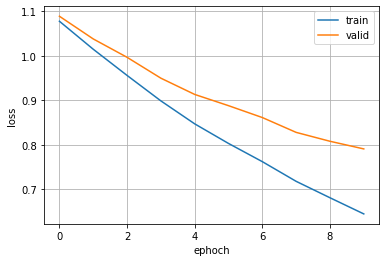

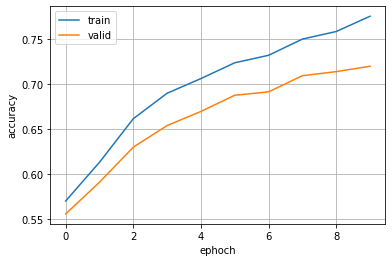

正解率（学習データ）：0.776
正解率（評価データ）：0.720


In [ ]:
plot(history['train_loss_values'], history['valid_loss_values'], NUM_EPOCHS, 'train', 'valid', 'ephoch', 'loss')
plot(history['train_accuracy_values'], history['valid_accuracy_values'], NUM_EPOCHS, 'train', 'valid', 'ephoch', 'accuracy')
print(f"正解率（学習データ）：{history['train_accuracy_values'][-1]:.3f}")
print(f"正解率（評価データ）：{history['valid_accuracy_values'][-1]:.3f}")

## 88. パラメータチューニング

問題85や問題87のコードを改変し，ニューラルネットワークの形状やハイパーパラメータを調整しながら，高性能なカテゴリ分類器を構築せよ．

6章と同様に[Optuna](https://tech.preferred.jp/ja/blog/optuna-release/)を利用してパラメータチューニングを行う。  
チューニング対象は以下の通り  


*   学習率
*   バッチサイズ
*   隠れ層の次元数
*   レイヤーの数

エポック数は30くらいで最適化を行ったほうが良い？🤔



In [ ]:
!pip install optuna

     |████████████████████████████████| 307kB 13.4MB/s 
     |████████████████████████████████| 174kB 17.6MB/s 
     |████████████████████████████████| 81kB 5.8MB/s 
     |████████████████████████████████| 81kB 8.1MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 143kB 20.4MB/s 
     |████████████████████████████████| 112kB 25.3MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11136 sha256=f2c2d0ae074a71b7495671a04380be7c969e3b636383e6c8c2d31b0e30fdc55d
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [ ]:
import optuna

In [ ]:
def objective_RNN(trial):
  # チューニング対象パラメータの設定
  #emb_size = int(trial.suggest_discrete_uniform('emb_size', 100, 400, 100))
  hidden_size = int(trial.suggest_discrete_uniform('hidden_size', 50 ,200, 50))
  learning_rate = trial.suggest_uniform('learning_rate', 1e-3, 1e-1)
  num_layers = int(trial.suggest_int('num_layers', 2, 4))
  batch_size = int(trial.suggest_discrete_uniform('batch_size', 16, 128, 16))

  # 固定パラメータの設定
  VOCAB_SIZE = len(word2id) + 1
  PADDING_IDX = len(word2id)
  OUTPUT_SIZE = 4
  NUM_EPOCHS = 10

  # デバイス指定
  device = torch.device('cuda')

  # モデルの定義
  model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, hidden_size, num_layers, emb_weights=weight, bidirectional=True, device=device)

  # 損失関数の定義
  criterion = nn.CrossEntropyLoss()

  # オプティマイザの定義
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  # 学習
  history = training(model, dataset_train, dataset_valid, batch_size, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

  # 損失値取得
  loss_valid, _ = loss_accuracy_score(model, dataset_valid, criterion, device)

  return loss_valid


In [ ]:
study = optuna.create_study()
study.optimize(objective_RNN, timeout=7200)

[I 2021-07-13 14:50:59,827] A new study created in memory with name: no-name-707e76c9-1724-41b2-a77b-19e139baf988
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



エポック数 : 1, 所要時間 : 31.552sec, 学習データの平均損失 : 1.1498, 検証データの損失1.1780
学習データの正答率 : 0.4711, 検証データの正答率0.4469

エポック数 : 2, 所要時間 : 29.232sec, 学習データの平均損失 : 1.1985, 検証データの損失1.2571
学習データの正答率 : 0.4549, 検証データの正答率0.4513

エポック数 : 3, 所要時間 : 28.759sec, 学習データの平均損失 : 1.2459, 検証データの損失1.3188
学習データの正答率 : 0.4435, 検証データの正答率0.4416

エポック数 : 4, 所要時間 : 29.175sec, 学習データの平均損失 : 1.2125, 検証データの損失1.2793
学習データの正答率 : 0.4554, 検証データの正答率0.4484

エポック数 : 5, 所要時間 : 28.561sec, 学習データの平均損失 : 1.2359, 検証データの損失1.3095
学習データの正答率 : 0.4481, 検証データの正答率0.4424

エポック数 : 6, 所要時間 : 29.127sec, 学習データの平均損失 : 1.2267, 検証データの損失1.2987
学習データの正答率 : 0.4514, 検証データの正答率0.4416

エポック数 : 7, 所要時間 : 28.667sec, 学習データの平均損失 : 1.2200, 検証データの損失1.2924
学習データの正答率 : 0.4595, 検証データの正答率0.4431

エポック数 : 8, 所要時間 : 28.634sec, 学習データの平均損失 : 1.2126, 検証データの損失1.2936
学習データの正答率 : 0.4832, 検証データの正答率0.4596

エポック数 : 9, 所要時間 : 28.607sec, 学習データの平均損失 : 1.1054, 検証データの損失1.1683
学習データの正答率 : 0.5529, 検証データの正答率0.5307

エポック数 : 10, 所要時間 : 28.751sec, 学習データの平均損失 : 1.1023, 検証データの損失1.1744
学習データの正答率 : 0.56

[I 2021-07-13 14:55:53,766] Trial 0 finished with value: 1.174403899316484 and parameters: {'hidden_size': 100.0, 'learning_rate': 0.0056230119353073, 'num_layers': 2, 'batch_size': 32.0}. Best is trial 0 with value: 1.174403899316484.


エポック数 : 1, 所要時間 : 24.875sec, 学習データの平均損失 : 1.2754, 検証データの損失1.3484
学習データの正答率 : 0.4427, 検証データの正答率0.4304

エポック数 : 2, 所要時間 : 24.573sec, 学習データの平均損失 : 1.2393, 検証データの損失1.3061
学習データの正答率 : 0.4494, 検証データの正答率0.4394

エポック数 : 3, 所要時間 : 24.560sec, 学習データの平均損失 : 1.2060, 検証データの損失1.2620
学習データの正答率 : 0.4564, 検証データの正答率0.4454

エポック数 : 4, 所要時間 : 24.579sec, 学習データの平均損失 : 1.4191, 検証データの損失1.4883
学習データの正答率 : 0.4054, 検証データの正答率0.3990

エポック数 : 5, 所要時間 : 24.723sec, 学習データの平均損失 : 1.3665, 検証データの損失1.4297
学習データの正答率 : 0.4049, 検証データの正答率0.4034

エポック数 : 6, 所要時間 : 24.682sec, 学習データの平均損失 : 1.2964, 検証データの損失1.3425
学習データの正答率 : 0.4015, 検証データの正答率0.4057

エポック数 : 7, 所要時間 : 24.542sec, 学習データの平均損失 : 1.2369, 検証データの損失1.3164
学習データの正答率 : 0.4803, 検証データの正答率0.4701

エポック数 : 8, 所要時間 : 24.664sec, 学習データの平均損失 : 1.2808, 検証データの損失1.3145
学習データの正答率 : 0.3846, 検証データの正答率0.3945

エポック数 : 9, 所要時間 : 24.631sec, 学習データの平均損失 : 1.6351, 検証データの損失1.7345
学習データの正答率 : 0.4013, 検証データの正答率0.3967

エポック数 : 10, 所要時間 : 24.640sec, 学習データの平均損失 : 1.3116, 検証データの損失1.3594
学習データの正答率 : 0.39

[I 2021-07-13 15:00:02,933] Trial 1 finished with value: 1.3594088190168923 and parameters: {'hidden_size': 150.0, 'learning_rate': 0.09889027486819042, 'num_layers': 2, 'batch_size': 112.0}. Best is trial 0 with value: 1.174403899316484.


エポック数 : 1, 所要時間 : 25.051sec, 学習データの平均損失 : 1.2908, 検証データの損失1.3723
学習データの正答率 : 0.4318, 検証データの正答率0.4237

エポック数 : 2, 所要時間 : 24.976sec, 学習データの平均損失 : 1.2355, 検証データの損失1.3139
学習データの正答率 : 0.4575, 検証データの正答率0.4461

エポック数 : 3, 所要時間 : 25.098sec, 学習データの平均損失 : 1.2966, 検証データの損失1.3677
学習データの正答率 : 0.4256, 検証データの正答率0.4222

エポック数 : 4, 所要時間 : 25.033sec, 学習データの平均損失 : 1.1795, 検証データの損失1.2352
学習データの正答率 : 0.5100, 検証データの正答率0.5037

エポック数 : 5, 所要時間 : 24.940sec, 学習データの平均損失 : 1.3765, 検証データの損失1.4488
学習データの正答率 : 0.3972, 検証データの正答率0.4012

エポック数 : 6, 所要時間 : 25.064sec, 学習データの平均損失 : 1.2943, 検証データの損失1.3432
学習データの正答率 : 0.3945, 検証データの正答率0.3990

エポック数 : 7, 所要時間 : 24.934sec, 学習データの平均損失 : 1.2317, 検証データの損失1.2863
学習データの正答率 : 0.4659, 検証データの正答率0.4543

エポック数 : 8, 所要時間 : 24.955sec, 学習データの平均損失 : 1.2469, 検証データの損失1.3414
学習データの正答率 : 0.4985, 検証データの正答率0.4798

エポック数 : 9, 所要時間 : 24.874sec, 学習データの平均損失 : 1.3492, 検証データの損失1.4267
学習データの正答率 : 0.4333, 検証データの正答率0.4289

エポック数 : 10, 所要時間 : 25.030sec, 学習データの平均損失 : 1.0273, 検証データの損失1.0783
学習データの正答率 : 0.62

[I 2021-07-13 15:04:15,525] Trial 2 finished with value: 1.078316998688246 and parameters: {'hidden_size': 150.0, 'learning_rate': 0.08590542248551278, 'num_layers': 2, 'batch_size': 64.0}. Best is trial 2 with value: 1.078316998688246.


エポック数 : 1, 所要時間 : 43.761sec, 学習データの平均損失 : 1.1513, 検証データの損失1.1801
学習データの正答率 : 0.5305, 検証データの正答率0.5045

エポック数 : 2, 所要時間 : 42.551sec, 学習データの平均損失 : 1.2921, 検証データの損失1.3646
学習データの正答率 : 0.4380, 検証データの正答率0.4207

エポック数 : 3, 所要時間 : 41.570sec, 学習データの平均損失 : 1.2340, 検証データの損失1.2844
学習データの正答率 : 0.4559, 検証データの正答率0.4379

エポック数 : 4, 所要時間 : 40.550sec, 学習データの平均損失 : 1.2388, 検証データの損失1.2790
学習データの正答率 : 0.4224, 検証データの正答率0.4192

エポック数 : 5, 所要時間 : 43.807sec, 学習データの平均損失 : 1.2764, 検証データの損失1.3431
学習データの正答率 : 0.4472, 検証データの正答率0.4334

エポック数 : 6, 所要時間 : 42.319sec, 学習データの平均損失 : 1.5152, 検証データの損失1.6048
学習データの正答率 : 0.4094, 検証データの正答率0.4042

エポック数 : 7, 所要時間 : 40.606sec, 学習データの平均損失 : 1.1735, 検証データの損失1.2166
学習データの正答率 : 0.5082, 検証データの正答率0.4940

エポック数 : 8, 所要時間 : 43.807sec, 学習データの平均損失 : 1.3912, 検証データの損失1.4289
学習データの正答率 : 0.3815, 検証データの正答率0.3840

エポック数 : 9, 所要時間 : 42.225sec, 学習データの平均損失 : 1.3572, 検証データの損失1.4341
学習データの正答率 : 0.4557, 検証データの正答率0.4371

エポック数 : 10, 所要時間 : 42.121sec, 学習データの平均損失 : 1.2929, 検証データの損失1.3504
学習データの正答率 : 0.45

[I 2021-07-13 15:11:23,433] Trial 3 finished with value: 1.3504006066237495 and parameters: {'hidden_size': 150.0, 'learning_rate': 0.06255790123622408, 'num_layers': 4, 'batch_size': 48.0}. Best is trial 2 with value: 1.078316998688246.


エポック数 : 1, 所要時間 : 37.506sec, 学習データの平均損失 : 1.1451, 検証データの損失1.2041
学習データの正答率 : 0.5023, 検証データの正答率0.4843

エポック数 : 2, 所要時間 : 37.326sec, 学習データの平均損失 : 1.1403, 検証データの損失1.2250
学習データの正答率 : 0.5350, 検証データの正答率0.5120

エポック数 : 3, 所要時間 : 37.988sec, 学習データの平均損失 : 1.1508, 検証データの損失1.2076
学習データの正答率 : 0.5119, 検証データの正答率0.4918

エポック数 : 4, 所要時間 : 37.608sec, 学習データの平均損失 : 1.1432, 検証データの損失1.2053
学習データの正答率 : 0.5118, 検証データの正答率0.4813

エポック数 : 5, 所要時間 : 37.295sec, 学習データの平均損失 : 1.1284, 検証データの損失1.1753
学習データの正答率 : 0.5233, 検証データの正答率0.4963

エポック数 : 6, 所要時間 : 37.211sec, 学習データの平均損失 : 1.0606, 検証データの損失1.0992
学習データの正答率 : 0.5738, 検証データの正答率0.5367

エポック数 : 7, 所要時間 : 38.045sec, 学習データの平均損失 : 1.1444, 検証データの損失1.2239
学習データの正答率 : 0.5521, 検証データの正答率0.5195

エポック数 : 8, 所要時間 : 37.809sec, 学習データの平均損失 : 1.1152, 検証データの損失1.1773
学習データの正答率 : 0.5439, 検証データの正答率0.5142

エポック数 : 9, 所要時間 : 37.272sec, 学習データの平均損失 : 1.1427, 検証データの損失1.1835
学習データの正答率 : 0.5177, 検証データの正答率0.5037



In [ ]:
print('Best trial')
trial = study.best_trial
print('loss_value : {:.3f}'.format(trial.value))
print('parameters')
for key,value in trial.params.items():
  print('\t{} : {:.3f}'.format(key,value))

得られたパラメータを使って実際に双方型RNNの学習をしてみる。

In [ ]:
# パラメータの設定
VOCAB_SIZE = len(word2id) + 1
EMB_SIZE = 300
PADDING_IDX = len(word2id)
OUTPUT_SIZE = 4
HIDDEN_SIZE = int(trial.params['hidden_size'])
LEARNING_RATE = trial.params['learning_rate']
NUM_EPOCHS = 30
NUM_LAYERS = int(trial.params['num_layers'])
BATCH_SIZE = int(trial.params['batch_size'])

# デバイス指定
device = torch.device('cuda')

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weight, bidirectional=True, device=device)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)



history = training(model, dataset_train, dataset_valid, BATCH_SIZE, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)


In [ ]:
plot(history['train_loss_values'], history['valid_loss_values'], NUM_EPOCHS, 'train', 'valid', 'ephoch', 'loss')
plot(history['train_accuracy_values'], history['valid_accuracy_values'], NUM_EPOCHS, 'train', 'valid', 'ephoch', 'accuracy')
print(f"正解率（学習データ）：{history['train_accuracy_values'][-1]:.3f}")
print(f"正解率（評価データ）：{history['valid_accuracy_values'][-1]:.3f}")

 
記事タイトルからカテゴリを予測するタスクでは、ロジスティック回帰モデル(6章)、単層/多層ニューラルネット(8章)、RNN(9章)の3つを用いたが、この中ではロジスティック回帰モデル(6章)と単層ニューラルネット(8章)が一番正答率が高い結果となった。

## 89. 事前学習済み言語モデルからの転移学習
事前学習済み言語モデル（例えばBERTなど）を出発点として，ニュース記事見出しをカテゴリに分類するモデルを構築せよ．

時間の都合上，以下サイトを参考にした．   
https://qiita.com/yamaru/items/63a342c844cff056a549


事前学習済みBERTモデルをファインチューニングして，ニュース記事見出しをカテゴリに分類するモデルを構築した．

めちゃくちゃ簡単なBERTの紹介
+ 中にTransformer(双方向)が入っている
+ Attentionを使っている
+ 事前学習をしている(あらかじめ教師なし学習をしている)
+ Fine-tuningに使えるパラメータを事前学習するモデルであり，BERT単体では予測はできない．
+ 基本となる単語表現は事前学習したパラメータを重みの初期値として使っている．


必要なライブラリをインポートする．  
BERTモデルを利用するためにtransformersライブラリをインストールしておく．

In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch import optim
from torch import cuda
import time
from matplotlib import pyplot as plt

次に、データをモデルに投入可能な形に整形する．  
まずは、PyTorchでよく利用される、特徴ベクトルとラベルベクトルを合わせて保持するDatasetを作成するためのクラスを定義する．  
このクラスにtokenizerを渡すことで、入力テキストの前処理を行い、指定した最長系列長までパディングした上で単語IDに変換する処理を実現できるようにしておく．  
とはいえ、BERT用にすべての処理が書かれたtokenizerそのものは、のちほどtranformersを通じて取得するため、クラス内で必要なものはtokenizerに渡す処理と結果を受け取る処理のみとなる。

In [ ]:
# Datasetの定義
class CreateDataset(Dataset):
  def __init__(self, X, y, tokenizer, max_len):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):  # len(Dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, index):  # Dataset[index]で返す値を指定
    text = self.X[index]
    inputs = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      pad_to_max_length=True
    )
    ids = inputs['input_ids']
    ## ここでのmaskはパッディング位置を示すマスクのこと
    mask = inputs['attention_mask']

    return {
      'ids': torch.LongTensor(ids),
      'mask': torch.LongTensor(mask),
      'labels': torch.Tensor(self.y[index])
    }

上記を用いてDatasetを作成する．
なお、英語版事前学習済みモデルとして利用できるBERTは、最高精度を目指した構成であるLARGEと、それよりパラメータの少ないBASE、それらのそれぞれについて小文字のみ（Uncased）と大文字小文字混在（Cased）の4パターンがある．  
今回は、手軽に試すことができるBASEのUncasedを使う．  
ここでのトークナイザーはサブワード単位で扱う．  

In [ ]:
# 正解ラベルのone-hot化
y_train = pd.get_dummies(train, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_valid = pd.get_dummies(valid, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_test = pd.get_dummies(test, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values

# Datasetの作成
max_len = 20
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset_train = CreateDataset(train['TITLE'], y_train, tokenizer, max_len)
dataset_valid = CreateDataset(valid['TITLE'], y_valid, tokenizer, max_len)
dataset_test = CreateDataset(test['TITLE'], y_test, tokenizer, max_len)


In [ ]:
for var in dataset_train[0]:
  print(f'{var}: {dataset_train[0][var]}')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


ids: tensor([  101, 25416,  9463,  1011, 10651,  1015,  1011,  2647,  2482,  4341,
         2039,  2005,  4369,  3204,  2004, 18730,  8980,   102,     0,     0])
mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])
labels: tensor([1., 0., 0., 0.])


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


1文目の文の情報を出力している． 
入力文字列がidsとしてID系列に変換されていることが確認できる。BERTでは、変換の過程で元の文の文頭と文末に特殊区切り文字である[CLS]と[SEP]がそれぞれ挿入されるため、それらも101と102として系列に含まれている。0はパディングを表す。  
正解ラベルもlabelsとしてone-hot形式で保持している。  
また、パディングの位置を表すmaskも合わせて保持し、学習時にidsと一緒にモデルに渡せるようにしておく。  

続いて、ネットワークを定義する。  
transfomersを用いることで、BERT部分はまるごとBertModelで表現可能である(簡単)。
その後、分類タスクに対応するため、BERTの出力ベクトルを受け取るドロップアウトと全結合層を定義すれば完成。

In [ ]:
# BERT分類モデルの定義
class BERTClass(torch.nn.Module):
  def __init__(self, drop_rate, otuput_size):
    super().__init__()
    self.bert = BertModel.from_pretrained('bert-base-uncased',return_dict=False)
    self.drop = torch.nn.Dropout(drop_rate)
    self.fc = torch.nn.Linear(768, otuput_size)  # BERTの出力に合わせて768次元を指定

  def forward(self, ids, mask):
    _, out = self.bert(ids, attention_mask=mask)
    out = self.fc(self.drop(out))
    return out

Datasetとネットワークが準備できたため、あとは普段通りの学習ループを作成する。  
ここでは一連の流れをtrain_model関数として定義している。

In [ ]:
def calculate_loss_and_accuracy(model, criterion, loader, device):
  """ 損失・正解率を計算"""
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model(ids, mask)

      # 損失計算
      loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1).cpu().numpy() # バッチサイズの長さの予測ラベル配列
      labels = torch.argmax(labels, dim=-1).cpu().numpy()  # バッチサイズの長さの正解ラベル配列
      total += len(labels)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  """モデルの学習を実行し、損失・正解率のログを返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      outputs = model(ids, mask)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

  return {'train': log_train, 'valid': log_valid}

パラメータを設定して、ファインチューニングを実行する。

In [ ]:
# パラメータの設定
DROP_RATE = 0.4
OUTPUT_SIZE = 4
BATCH_SIZE = 32
NUM_EPOCHS = 4
LEARNING_RATE = 2e-5

# モデルの定義
model = BERTClass(DROP_RATE, OUTPUT_SIZE)

# 損失関数の定義
criterion = torch.nn.BCEWithLogitsLoss()

# オプティマイザの定義
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = 'cuda' if cuda.is_available() else 'cpu'

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, device=device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will

epoch: 1, loss_train: 0.0867, accuracy_train: 0.9523, loss_valid: 0.1169, accuracy_valid: 0.9229, 72.7893sec
epoch: 2, loss_train: 0.0472, accuracy_train: 0.9744, loss_valid: 0.1026, accuracy_valid: 0.9326, 72.6740sec
epoch: 3, loss_train: 0.0270, accuracy_train: 0.9888, loss_valid: 0.0986, accuracy_valid: 0.9349, 72.5990sec
epoch: 4, loss_train: 0.0196, accuracy_train: 0.9924, loss_valid: 0.1203, accuracy_valid: 0.9251, 72.4667sec


結果を見る

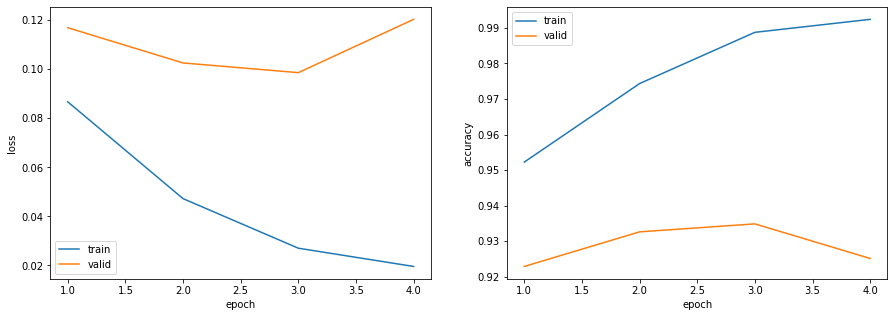

In [ ]:
# ログの可視化
x_axis = [x for x in range(1, len(log['train']) + 1)]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x_axis, np.array(log['train']).T[0], label='train')
ax[0].plot(x_axis, np.array(log['valid']).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(x_axis, np.array(log['train']).T[1], label='train')
ax[1].plot(x_axis, np.array(log['valid']).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [ ]:
# 正解率の算出
def calculate_accuracy(model, dataset, device):
  # Dataloaderの作成
  loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 順伝播 + 予測値の取得 + 正解数のカウント
      outputs = model.forward(ids, mask)
      pred = torch.argmax(outputs, dim=-1).cpu().numpy()
      labels = torch.argmax(labels, dim=-1).cpu().numpy()
      total += len(labels)
      correct += (pred == labels).sum().item()

  return correct / total

print(f'正解率（学習データ）：{calculate_accuracy(model, dataset_train, device):.3f}')
print(f'正解率（検証データ）：{calculate_accuracy(model, dataset_valid, device):.3f}')
print(f'正解率（評価データ）：{calculate_accuracy(model, dataset_test, device):.3f}')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


正解率（学習データ）：0.992
正解率（検証データ）：0.925
正解率（評価データ）：0.939
